1639
669


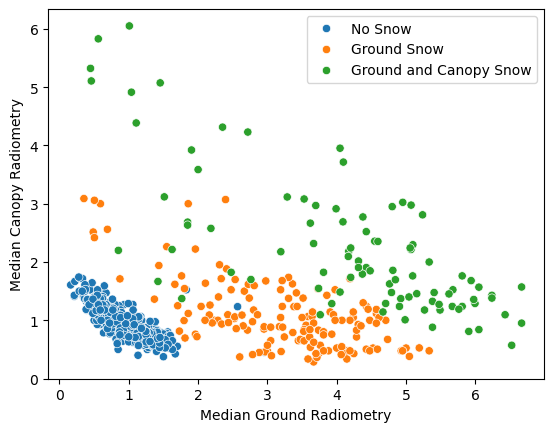

In [1]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_70m_1kmsmallbox_noprior_ta_v7.pkl')
# df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy750m_noprior_ta.pkl')

# df = df_.copy()
# print(df)
# mask = df['beam'] == 3
# df.loc[mask, ['pv','pg','Ev','Eg']] /= 0.85

# First create masked columns
df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier'] == 1), df['Ev'], np.nan)
df['Eg_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Ev'], np.nan)
df['forest_type'] = np.where(df['segment_landcover']<119, 'closed', 'open')

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'Eg_weak': 'median',
    'Ev_weak': 'median',
    'data_quantity': 'max',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
    'forest_type': lambda x: pd.Series.mode(x).iloc[0],
}).reset_index()
df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
print(len(df_grouped[((df_grouped['FSC'] < 0.001)|(df_grouped['FSC'] > 0.999))]))
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
# camera_counts = df_grouped['camera'].value_counts()
data = df_grouped[((df_grouped['FSC'] <= 0.005)|(df_grouped['FSC'] >= 0.995))
    &((df_grouped['TreeSnow'] == 0)|(df_grouped['TreeSnow'] == 1))
    &(df_grouped['Eg_strong'] <= 16)&(df_grouped['Ev_strong'] <= 16)#&(df_grouped['pvpg'] <= 7.5)
    # &(df_grouped['pv_ratio_mean'] >= 1.2)
    &(df_grouped['Eg_strong']/df_grouped['Eg_weak'] >= 1.2)
    # &((df_grouped['layer_flag'] <= 0.6)&(df_grouped['msw_flag'] <= 3.0))
    &(df_grouped['data_quantity'] >= 25)]
data.loc[:, 'JointSnow'] = data['JointSnow'].apply(lambda x: np.round(x))
camera_counts = data['camera'].value_counts()

#TAKE OUT TEST DATA
data = data[~data['camera'].isin(['delta_junction', 'marcell_MN', 'glees'])]

data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})
print(len(data))

# plt.figure()
# sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pv', hue='Conditions')#, size='data_quantity')
# plt.xlabel('estimated pg')
# plt.ylabel('estimated pv')
# plt.xlim(0,16)
# plt.ylim(0,14)
# # plt.plot([4.2,0],[0,9],'r--') #LOF10_bin20_DW 570 points
# # plt.plot([5,0],[0,7.5],'r--') #LOF10_bin30_DW 596 points
#                                 #LOF10_bin20 578 points
# plt.legend(loc='best')
# plt.show()

# plt.figure()
# sns.scatterplot(data = data.sort_values('JointSnow'), x='pvpg', y='pv', hue='Conditions')#, size='data_quantity')
# plt.xlabel('estimated pv/pg')
# plt.ylabel('estimated pv')
# # plt.xlim(0,3)
# # plt.ylim(0,12)
# plt.legend(loc='best')
# plt.show()

# plt.figure()
# sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pvpg', hue='Conditions')#, size='data_quantity')
# plt.xlabel('estimated pg')
# plt.ylabel('estimated pv/pg')
# # plt.xlim(0,20)
# # plt.ylim(0,20)
# plt.legend(loc='best')
# plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='Eg_strong', y='Ev_strong', hue='Conditions')#, size='data_quantity')
plt.xlabel('Median Ground Radiometry')
plt.ylabel('Median Canopy Radiometry')
# plt.xlim(0,20)
# plt.ylim(0,20)
# plt.plot([2.5,0],[0,2.5],'r--') #LOF10_bin20 570 points
# plt.plot([2.5,0],[0,2.5],'r--') #LOF10_bin30 596 points
plt.legend(loc='best')
plt.show()

# data[(data['forest_type']=='closed')&(data['camera']=='varrio')] #glees, ojk, oregon, torgnon, varrio

#### Logistic Regression

/tmp/ipykernel_2909147/2744350098.py:83: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(X[mask, 0], X[mask, 1],


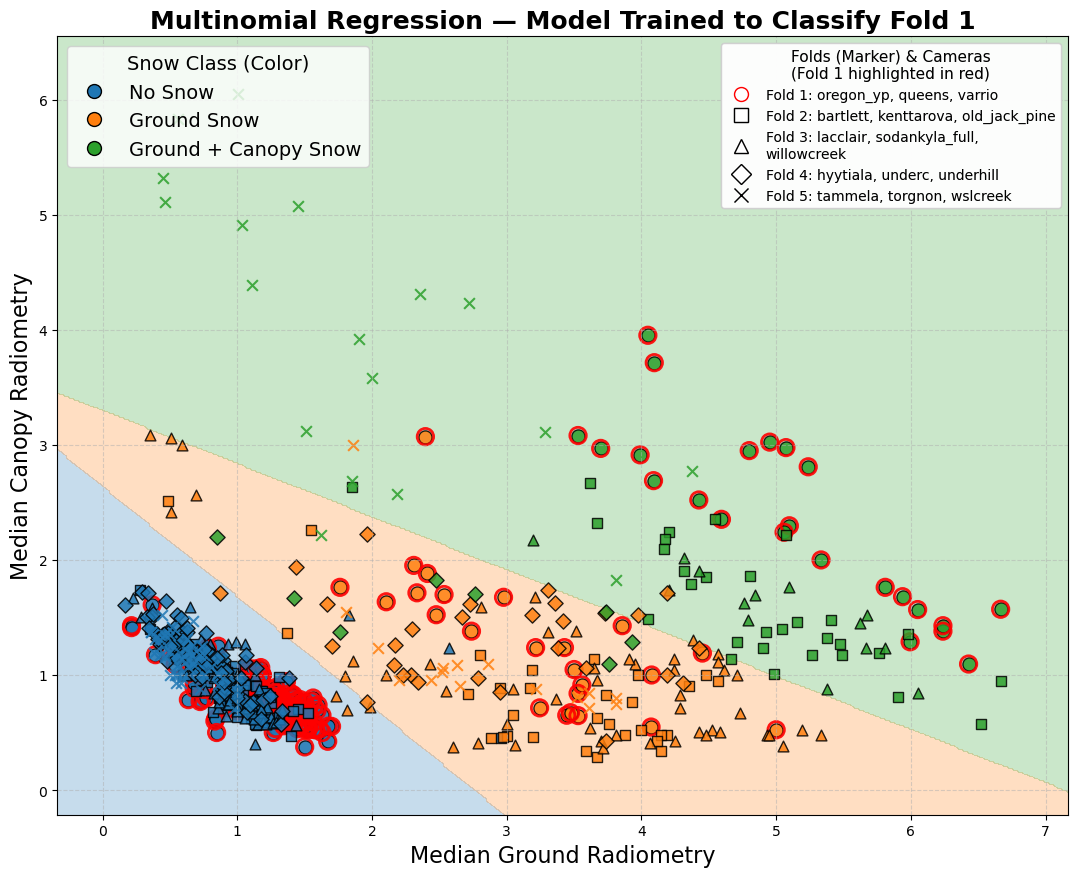

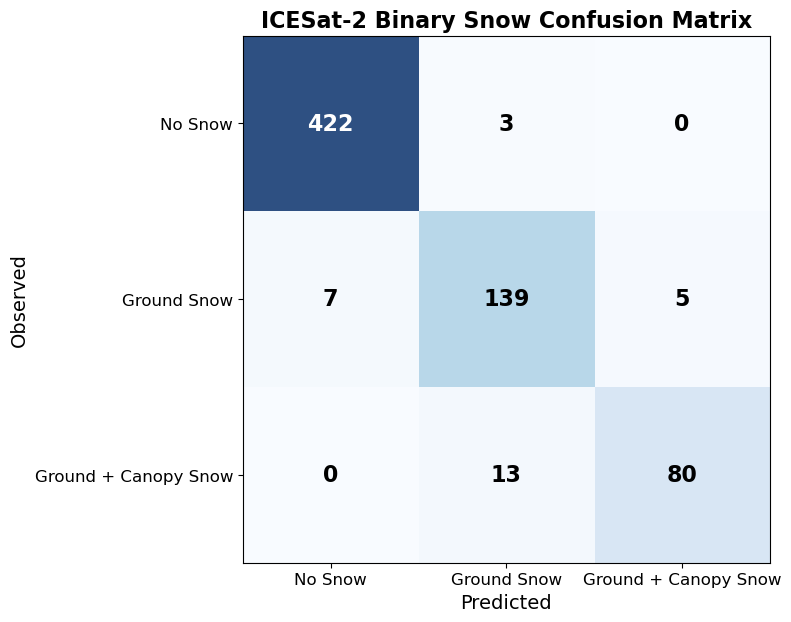

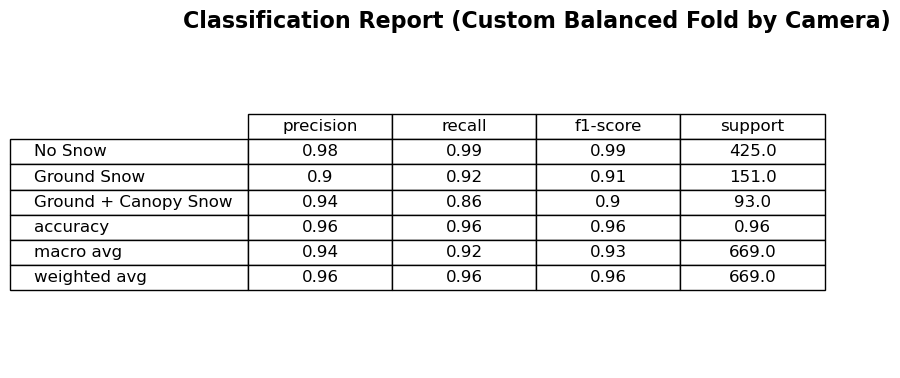

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from textwrap import fill

# --- Prepare Data ---
data['JointSnowRounded'] = data['JointSnow'].round().astype(int)
features = ['Eg_strong', 'Ev_strong']
target = 'JointSnowRounded'

X = data[features].values
y = data[target].values

# --- Create Custom Balanced GroupKFold on "camera" ---
n_splits = 5

camera_counts = data['camera'].value_counts()
sorted_cameras = camera_counts.index.tolist()

camera_to_fold = {}
for i, cam in enumerate(sorted_cameras):
    camera_to_fold[cam] = i % n_splits

group_indices = data['camera'].map(camera_to_fold).values

# Containers / styling
labels_str = ['No Snow', 'Ground Snow', 'Ground + Canopy Snow']
class_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
group_markers = ['o', 's', '^', 'D', 'x']         # Marker per fold

all_y_true = []
all_y_pred = []

# Keep fold->cameras (for legend block)
fold_to_cameras = {f: [] for f in range(n_splits)}
for cam, f in camera_to_fold.items():
    fold_to_cameras[f].append(cam)

# --- Cross-validation to gather overall metrics (unchanged) ---
for fold_idx in range(n_splits):
    test_idx = np.where(group_indices == fold_idx)[0]
    train_idx = np.where(group_indices != fold_idx)[0]

    cv_model = LogisticRegression(solver='lbfgs',
                                  max_iter=1000, random_state=42, penalty=None)
    cv_model.fit(X[train_idx], y[train_idx])
    y_pred = cv_model.predict(X[test_idx])

    all_y_true.extend(y[test_idx])
    all_y_pred.extend(y_pred)

# === NEW: Train the "final_model" specifically for predicting Fold 1 (index 0) ===
first_fold = 0
first_test_idx = np.where(group_indices == first_fold)[0]
first_train_idx = np.where(group_indices != first_fold)[0]

final_model = LogisticRegression(solver='lbfgs',
                                 max_iter=1000, random_state=42, penalty=None)
final_model.fit(X[first_train_idx], y[first_train_idx])

# --- Mesh for decision boundary using the Fold 1 model ---
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = final_model.predict(grid).reshape(xx.shape)

# --- Plot ---
fig, ax = plt.subplots(figsize=(11, 9))
plt.rcParams.update({'font.size': 14})

# Decision boundary background (Fold 1 model)
ax.contourf(xx, yy, Z, alpha=0.25, levels=[-0.5, 0.5, 1.5, 2.5], colors=class_colors)

# Overlay all data; highlight Fold 1 points
for fold in range(n_splits):
    for cls in [0, 1, 2]:
        mask = (group_indices == fold) & (y == cls)
        # Base points
        ax.scatter(X[mask, 0], X[mask, 1],
                   color=class_colors[cls],
                   marker=group_markers[fold],
                   edgecolor='k',
                   s=60 if fold != first_fold else 90,   # larger for Fold 1
                   alpha=0.85)
        # Add a red halo for Fold 1 points to highlight
        if fold == first_fold and np.any(mask):
            ax.scatter(X[mask, 0], X[mask, 1],
                       facecolors='none',
                       edgecolors='red',
                       linewidths=2.0,
                       marker=group_markers[fold],
                       s=140,
                       alpha=0.9)

# --- Class legend (color) ---
class_handles = [
    plt.Line2D([0], [0], marker='o', linestyle='',
               markerfacecolor=class_colors[i], markeredgecolor='k', markersize=10)
    for i in range(3)
]
class_legend = ax.legend(class_handles, labels_str,
                         title='Snow Class (Color)', loc='upper left', frameon=True)
ax.add_artist(class_legend)

# --- Combined Fold (marker) + camera list block in TOP RIGHT ---
fold_handles = []
fold_labels = []
wrap_width = 44

for f in range(n_splits):
    # red edge for Fold 1 in legend too
    handle = plt.Line2D([0], [0], marker=group_markers[f], linestyle='',
                        markerfacecolor='white',
                        markeredgecolor=('red' if f == first_fold else 'k'),
                        markersize=10, linewidth=2)
    cams = sorted(fold_to_cameras[f])
    cams_text = ", ".join(cams) if cams else "(no cameras)"
    label = f"Fold {f+1}: {cams_text}"
    fold_handles.append(handle)
    fold_labels.append(fill(label, width=wrap_width))

fold_legend = ax.legend(fold_handles, fold_labels,
                        title='Folds (Marker) & Cameras\n(Fold 1 highlighted in red)',
                        loc='upper right', frameon=True, fontsize=10, title_fontsize=11)
ax.add_artist(fold_legend)

# --- Labels ---
ax.set_xlabel('Median Ground Radiometry', fontsize=16)
ax.set_ylabel('Median Canopy Radiometry', fontsize=16)
ax.set_title('Multinomial Regression — Model Trained to Classify Fold 1',
             fontsize=18, weight='bold')
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# --- Confusion Matrix (All folds) ---
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(all_y_true, all_y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, cmap='Blues', alpha=0.85)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', fontsize=16, fontweight='bold',
                color='white' if cm[i, j] > cm.max()/2 else 'black')

ax.set_xticks(np.arange(3))
ax.set_yticks(np.arange(3))
ax.set_xticklabels(labels_str, fontsize=12)
ax.set_yticklabels(labels_str, fontsize=12)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Observed', fontsize=14)
plt.title('ICESat-2 Binary Snow Confusion Matrix', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# --- Classification Report (All folds) ---
from sklearn.metrics import classification_report
report_dict = classification_report(all_y_true, all_y_pred,
                                    target_names=labels_str, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(2)

fig, ax = plt.subplots(figsize=(9, 4))
ax.axis('off')
table = ax.table(cellText=report_df.values,
                 colLabels=report_df.columns,
                 rowLabels=report_df.index,
                 loc='center',
                 cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.4)
plt.title('Classification Report (Custom Balanced Fold by Camera)', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()


# Fractional

741


/tmp/ipykernel_2909147/1776219223.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)


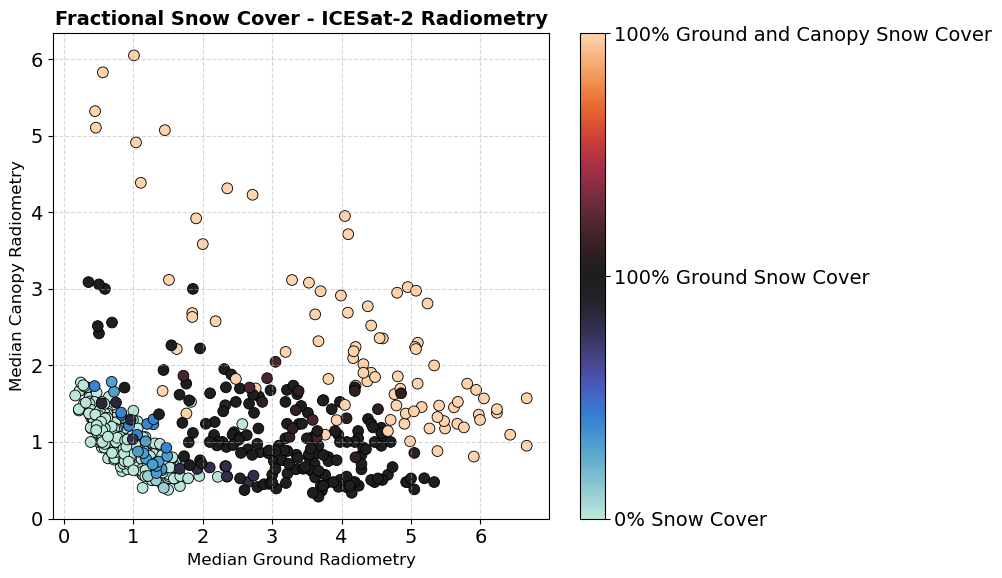

In [3]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_70m_1kmsmallbox_noprior_ta_v7.pkl')
# print(df.columns)

df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Ev'], np.nan)
df['Eg_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Ev'], np.nan)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'Eg_weak': 'median',
    'Ev_weak': 'median',
    'data_quantity': 'max',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()

# for i in df_grouped.groupby(['camera','date']).size().reset_index().rename(columns={0:'count'}):
    # print(i)
# print(df_grouped.groupby(['camera','date']).size().reset_index().rename(columns={0:'count'}).to_string())


df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
frac_data = df_grouped[((df_grouped['FSC'] >= 0.00)&(df_grouped['FSC'] <= 1.00))
    &(df_grouped['Eg_strong'] <= 16)&(df_grouped['Ev_strong'] <= 16)#&(df_grouped['pvpg'] <= 7.5)
    # &(df_grouped['pv_ratio_mean'] >= 1.2)
    &(df_grouped['Eg_strong']/df_grouped['Eg_weak'] >= 1.15)
    # &((df_grouped['layer_flag'] <= 0.6)&(df_grouped['msw_flag'] <= 3.0))
    &(df_grouped['data_quantity'] >= 26)]
frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)

#TAKE OUT TEST DATA
frac_data = frac_data[~frac_data['camera'].isin(['delta_junction', 'marcell_MN', 'glees'])]

print(len(frac_data))

plt.figure(figsize=(10, 6))
ax = plt.gca()
scatter = sns.scatterplot(
    data=frac_data.sort_values('FSC'),
    x='Eg_strong', y='Ev_strong',
    hue='JointSnow', palette='icefire', edgecolor='black', s=60, ax=ax, legend=False
)

# Add manual colorbar
norm = plt.Normalize(0, 2)
sm = plt.cm.ScalarMappable(cmap='icefire', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label('Snow Cover Category', fontsize=12)
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['0% Snow Cover', '100% Ground Snow Cover', '100% Ground and Canopy Snow Cover'])

# Set axes and title
plt.xlabel('Median Ground Radiometry', fontsize=12)
plt.ylabel('Median Canopy Radiometry', fontsize=12)
plt.title('Fractional Snow Cover - ICESat-2 Radiometry', fontsize=14, weight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig('poster_reclassified_FSC_icefire.svg')
plt.show()


Percentage of all data from target sites (torgnon, glees, wslcreek): 2.91%
Percentage of Partial Snow = Yes from target sites: 3.33%


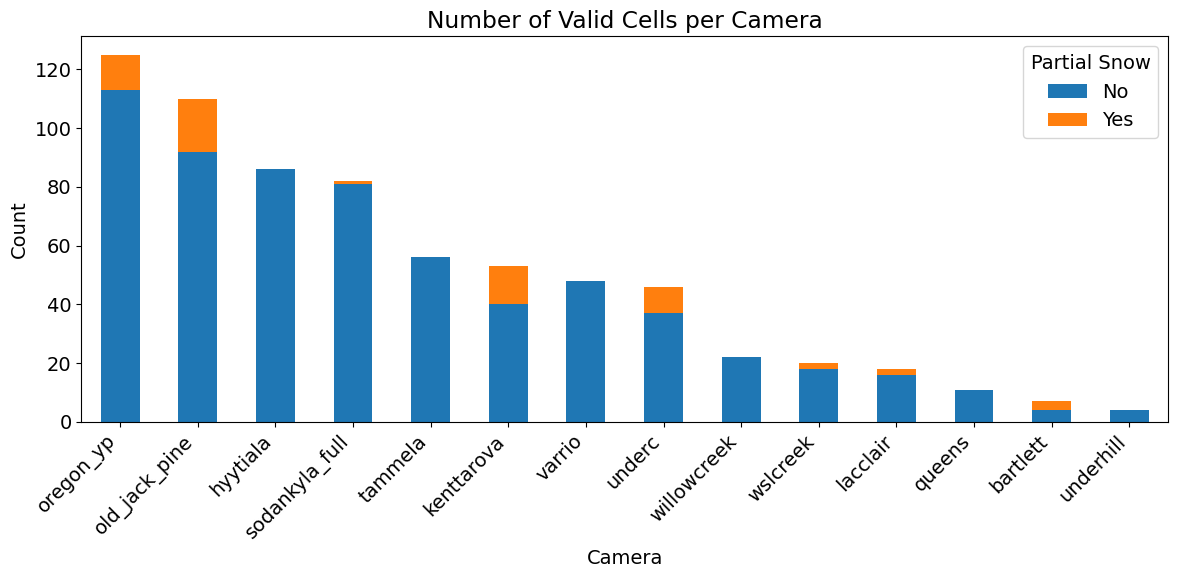

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Categorize FSC values
frac_data['Partial Snow'] = frac_data['FSC'].apply(lambda x: 'No' if x in [0, 1] else 'Yes')

# Count occurrences per camera per FSC category
counts = frac_data.groupby(['camera', 'Partial Snow']).size().unstack(fill_value=0)

# Sort cameras by total count
counts = counts.loc[counts.sum(axis=1).sort_values(ascending=False).index]

# --- Percentage calculations ---
target_sites = ['torgnon', 'glees', 'wslcreek']

# Overall percentage of data from target sites
total_all = len(frac_data)
total_target = len(frac_data[frac_data['camera'].isin(target_sites)])
perc_target_all = 100 * total_target / total_all

# Percentage of Partial Snow = Yes from target sites
partial_yes_all = len(frac_data[frac_data['Partial Snow'] == 'Yes'])
partial_yes_target = len(frac_data[(frac_data['Partial Snow'] == 'Yes') & 
                                   (frac_data['camera'].isin(target_sites))])
perc_target_partial = 100 * partial_yes_target / partial_yes_all

print(f"Percentage of all data from target sites (torgnon, glees, wslcreek): {perc_target_all:.2f}%")
print(f"Percentage of Partial Snow = Yes from target sites: {perc_target_partial:.2f}%")

# --- Plot ---
counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Camera')
plt.ylabel('Count')
plt.title('Number of Valid Cells per Camera')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


/tmp/ipykernel_2860417/1815740078.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  face_cmap = get_cmap(cmap_name)
/tmp/ipykernel_2860417/1815740078.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  edge_cmap = get_cmap('tab20')


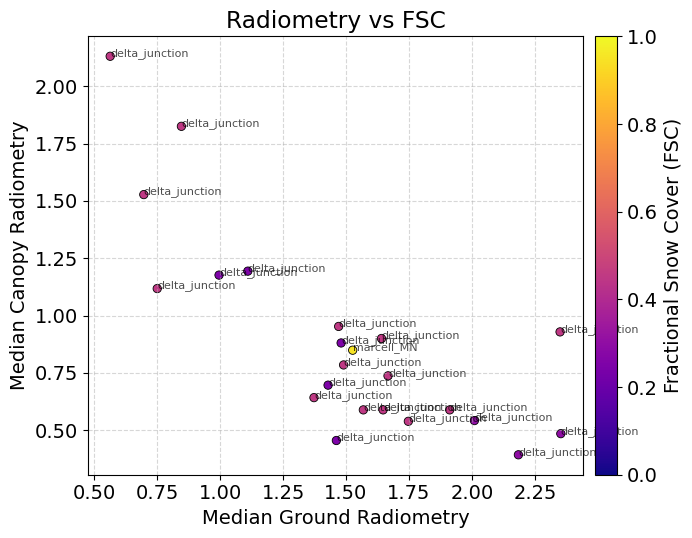

/tmp/ipykernel_2860417/1815740078.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  face_cmap = get_cmap(cmap_name)
/tmp/ipykernel_2860417/1815740078.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  edge_cmap = get_cmap('tab20')


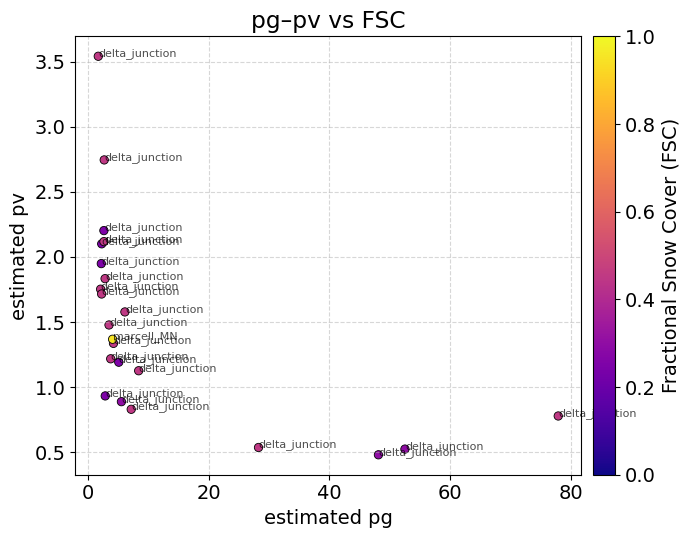

23


,camera,date,lat,lon,pvpg,pv,pg,Eg_strong,Ev_strong,Eg_weak,...,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,JointSnowBinary
76,delta_junction,02/05/2021,63.876595,-145.771136,0.160619,0.889016,5.534949,2.009804,0.541522,0.845238,...,0.882945,0.30,0.0,0.000000,27.0,0.0,1.538625,1.538625,0.30,0.30
203,delta_junction,26/04/2024,63.885605,-145.758869,0.327043,0.933241,2.853571,1.461538,0.454545,0.666667,...,0.255701,0.25,0.0,0.097222,61.0,0.0,1.259742,1.259742,0.25,0.25
201,delta_junction,26/04/2024,63.876595,-145.757086,0.884886,1.948915,2.202447,1.428571,0.696154,0.721154,...,0.256604,0.25,0.0,0.000000,61.0,0.0,1.610417,1.610417,0.25,0.25
199,delta_junction,26/04/2024,63.867586,-145.755330,0.836787,2.202278,2.631826,1.109890,1.193750,0.500000,...,0.253921,0.25,0.0,0.000000,61.0,0.0,1.823052,1.823052,0.25,0.25
197,delta_junction,26/04/2024,63.849568,-145.684090,0.925109,2.100706,2.270767,0.995475,1.176471,0.500000,...,0.348518,0.25,0.0,0.000000,61.0,0.0,1.691767,1.691767,0.25,0.25
101,delta_junction,03/05/2020,63.912632,-145.681313,0.803099,2.117687,2.636893,0.696691,1.527864,0.555556,...,0.356858,0.45,0.0,0.000000,15.0,0.0,1.807116,1.807116,0.45,0.45
98,delta_junction,03/05/2020,63.903623,-145.679179,0.648280,1.833468,2.828205,1.470588,0.952381,0.666667,...,0.365786,0.45,0.0,0.000000,15.0,0.0,1.763695,1.763695,0.45,0.45
96,delta_junction,03/05/2020,63.903623,-145.811742,0.839843,1.752520,2.086724,0.750000,1.117647,0.300000,...,0.219662,0.45,0.0,0.000000,15.0,0.0,1.451572,1.451572,0.45,0.45
95,delta_junction,03/05/2020,63.894614,-145.677640,0.134218,1.126400,8.392321,1.640789,0.899749,0.923077,...,0.378281,0.45,0.0,0.000000,15.0,0.0,1.822338,1.822338,0.45,0.45
94,delta_junction,03/05/2020,63.894614,-145.743494,0.760580,1.715549,2.255579,1.372549,0.641711,0.690476,...,0.195294,0.45,0.0,0.000000,15.0,0.0,1.472335,1.472335,0.45,0.45


In [6]:
from scripts.imports import *
import matplotlib as mpl
from matplotlib.cm import get_cmap

df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_60m_1kmsmallbox_noprior_ta_v7.pkl')

df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Ev'], np.nan)
df['Eg_weak']   = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_weak']   = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Ev'], np.nan)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'Eg_weak': 'median',
    'Ev_weak': 'median',
    'data_quantity': 'max',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()

df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']

frac_data = df_grouped[
    (df_grouped['FSC'].between(0.0, 1.0, inclusive='neither')) &
    (df_grouped['Eg_strong'] <= 16) & (df_grouped['Ev_strong'] <= 16) &
    # ((df_grouped['layer_flag'] <= 0.6) & (df_grouped['msw_flag'] <= 3.0)) &
    (df_grouped['data_quantity'] >= 26) &
    (df_grouped['Eg_strong']/df_grouped['Eg_weak'] >= 1.15)
].copy()

frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)

#TAKE OUT TEST DATA
frac_data = frac_data[frac_data['camera'].isin(['delta_junction', 'marcell_MN', 'glees'])]

# --- Helper: scatter with FSC colorbar + date edge-color legend (top-right) ---
def scatter_fsc_with_date_edges(data, x, y, xlab, ylab, title=None, cmap_name='plasma'):
    fig, ax = plt.subplots(figsize=(7.2, 5.6))

    fsc = data['FSC'].to_numpy(dtype=float)
    face_cmap = get_cmap(cmap_name)
    vmin, vmax = 0.0, 1.0

    date_codes, _dates = pd.factorize(data['date'])
    edge_cmap = get_cmap('tab20')
    edge_colors = edge_cmap((date_codes % edge_cmap.N) / edge_cmap.N)

    sc = ax.scatter(
        data[x], data[y],
        c=fsc, cmap=face_cmap, vmin=vmin, vmax=vmax,
        s=36, linewidths=0.6, edgecolors='black'
    )

    # Annotate each point with its camera name
    for i, row in data.iterrows():
        ax.annotate(row['camera'], (row[x], row[y]), fontsize=8, alpha=0.7)

    cbar = fig.colorbar(sc, ax=ax, pad=0.02)
    cbar.set_label('Fractional Snow Cover (FSC)')

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    if title:
        ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# --- Plot 1: Eg_strong vs Ev_strong (color = FSC, edge color = date) ---
scatter_fsc_with_date_edges(
    frac_data.sort_values('FSC'),
    x='Eg_strong', y='Ev_strong',
    xlab='Median Ground Radiometry',
    ylab='Median Canopy Radiometry',
    title='Radiometry vs FSC',
)

# --- Plot 2: pg vs pv (color = FSC, edge color = date) ---
scatter_fsc_with_date_edges(
    frac_data.sort_values('FSC'),
    x='pg', y='pv',
    xlab='estimated pg', ylab='estimated pv',
    title='pg–pv vs FSC'
)

print(len(frac_data))
frac_data.sort_values('camera')


### Model Testing


Camera-to-Fold Assignment:

Fold 1:
  - oregon_yp: 129 total (117 binary, 12 fractional)
  - queens: 11 total (11 binary, 0 fractional)
  >> Fold 1 Total: 140 (128 binary, 12 fractional)

Fold 2:
  - old_jack_pine: 110 total (92 binary, 18 fractional)
  - tammela: 56 total (56 binary, 0 fractional)
  >> Fold 2 Total: 166 (148 binary, 18 fractional)

Fold 3:
  - sodankyla_full: 88 total (87 binary, 1 fractional)
  - wslcreek: 22 total (20 binary, 2 fractional)
  - lacclair: 21 total (19 binary, 2 fractional)
  - bartlett: 9 total (6 binary, 3 fractional)
  >> Fold 3 Total: 140 (132 binary, 8 fractional)

Fold 4:
  - kenttarova: 57 total (44 binary, 13 fractional)
  - varrio: 57 total (57 binary, 0 fractional)
  - willowcreek: 43 total (43 binary, 0 fractional)
  >> Fold 4 Total: 157 (144 binary, 13 fractional)

Fold 5:
  - underc: 46 total (37 binary, 9 fractional)
  - hyytiala: 86 total (86 binary, 0 fractional)
  - underhill: 5 total (5 binary, 0 fractional)
  - torgnon: 1 total (1 b

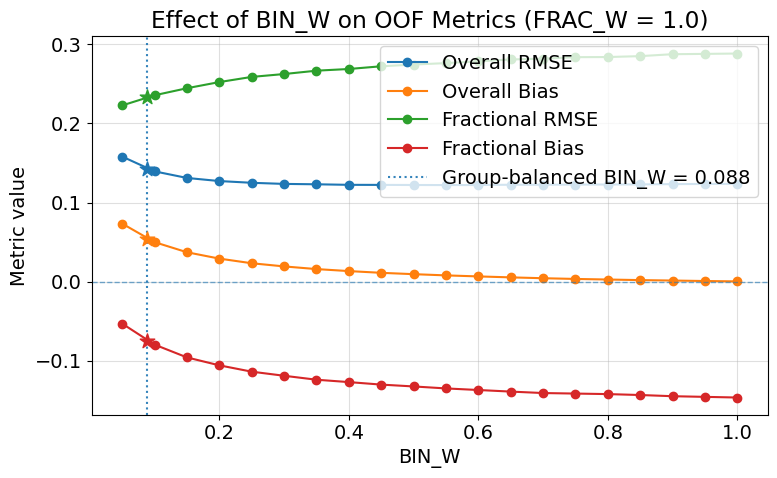

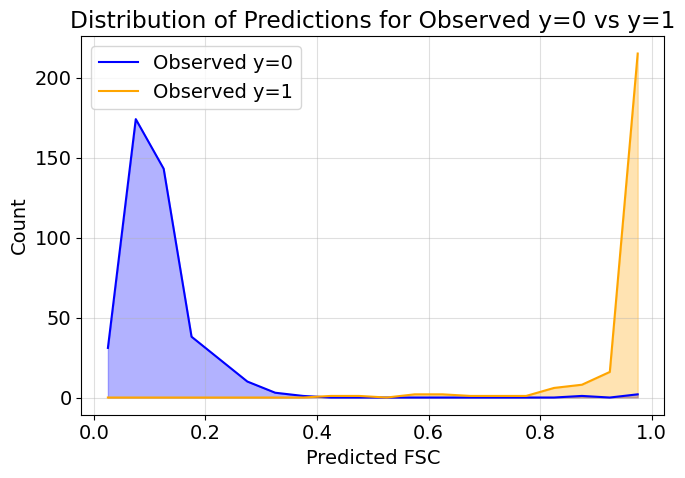

/tmp/ipykernel_2909147/4026209317.py:305: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(Eg_arr[m], Ev_arr[m],


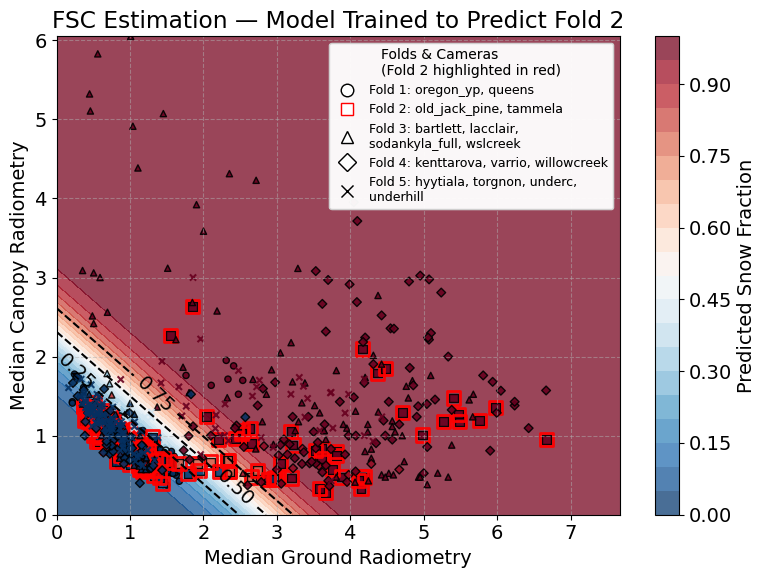

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, confusion_matrix
import statsmodels.api as sm
from textwrap import fill

# ---------------- weights ----------------
FRAC_W = 1.0   # weight for fractional labels (0<y<1)
BIN_W  = 0.1  # default weight for binary labels (y in {0,1})

# Toggle for contour scatter plot overlay points
SHOW_FRACTIONAL_ONLY = False

def make_weights(y_series, frac_w=FRAC_W, bin_w=BIN_W):
    yv = y_series.values.astype(float)
    w = np.where((yv > 0) & (yv < 1), frac_w, bin_w).astype(float)
    return w

def weighted_rmse(y_true, y_pred, frac_weight=FRAC_W, bin_weight=BIN_W):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    w = np.where((y_true > 0) & (y_true < 1), frac_weight, bin_weight)
    return np.sqrt(np.sum(w * (y_true - y_pred) ** 2) / np.sum(w))

def fsc_bin(val):
    if val < 0.05:
        return "[0,0.05)"
    elif val < 0.5:
        return "[0.05,0.5)"
    elif val < 0.95:
        return "[0.5,0.95)"
    else:
        return "[0.95,1]"

def sharpen(p, a=0.0, b=1.0):
    # simple linear clamp to [0,1] (keeps compatibility with earlier code)
    p2 = (p - a) / (b - a)
    return np.clip(p2, 0, 1)

# --- Preprocessing ---
df = frac_data.dropna(subset=["Eg_strong", "Ev_strong", "JointSnowBinary", "date", "camera"]).copy()
combined = df.copy()

X = combined[["Eg_strong", "Ev_strong"]]
y = combined["JointSnowBinary"]

# --- Balanced Group Split by Camera ---
n_splits = 5
camera_groups = combined.groupby("camera")
sorted_cameras = sorted(camera_groups.groups.keys(), key=lambda cam: len(camera_groups.get_group(cam)), reverse=True)

folds = [[] for _ in range(n_splits)]
fold_sample_counts = [0] * n_splits
fold_frac_counts = [0] * n_splits
camera_to_fold = {}

# Assign cameras with fractional data first
for cam in sorted_cameras:
    cam_data = camera_groups.get_group(cam)
    n = len(cam_data)
    has_fractional = ((cam_data["JointSnowBinary"] > 0) & (cam_data["JointSnowBinary"] < 1)).any()
    if has_fractional:
        idx = np.argmin(fold_frac_counts)
        folds[idx].extend(cam_data.index.tolist())
        fold_sample_counts[idx] += n
        fold_frac_counts[idx] += ((cam_data["JointSnowBinary"] > 0) & (cam_data["JointSnowBinary"] < 1)).sum()
        camera_to_fold[cam] = idx

# Remaining cameras
for cam in sorted_cameras:
    if cam in camera_to_fold:
        continue
    cam_data = camera_groups.get_group(cam)
    n = len(cam_data)
    idx = np.argmin(fold_sample_counts)
    folds[idx].extend(cam_data.index.tolist())
    fold_sample_counts[idx] += n
    camera_to_fold[cam] = idx

# --- Fold prep ---
group_markers = ['o', 's', '^', 'D', 'x'][:n_splits]
fold_to_cameras = {f: [] for f in range(n_splits)}
for cam, f in camera_to_fold.items():
    fold_to_cameras[f].append(cam)
row_fold_idx = combined['camera'].map(camera_to_fold)

print("\nCamera-to-Fold Assignment:")
for i in range(n_splits):
    fold_cams = [cam for cam, f in camera_to_fold.items() if f == i]
    total_bin = total_frac = 0
    print(f"\nFold {i+1}:")
    for cam in fold_cams:
        cam_data = camera_groups.get_group(cam)
        n_total = len(cam_data)
        n_frac = ((cam_data["JointSnowBinary"] > 0) & (cam_data["JointSnowBinary"] < 1)).sum()
        n_bin = n_total - n_frac
        total_bin += n_bin
        total_frac += n_frac
        print(f"  - {cam}: {n_total} total ({n_bin} binary, {n_frac} fractional)")
    print(f"  >> Fold {i+1} Total: {total_bin + total_frac} ({total_bin} binary, {total_frac} fractional)")

# --- Splits ---
merged_splits = []
all_indices = set(combined.index)
for i in range(n_splits):
    val_idx = folds[i]
    train_idx = list(all_indices - set(val_idx))
    merged_splits.append((train_idx, val_idx))

# --- CV ---
rmses, rmses_frac, biases, biases_frac, bin_accuracies = [], [], [], [], []
all_y_val, all_y_pred = [], []
all_Eg_val, all_Ev_val, all_yval_color = [], [], []
all_actual_bins, all_pred_bins = [], []

family = sm.families.Binomial()

for train_idx, val_idx in merged_splits:
    X_tr, X_val = X.loc[train_idx], X.loc[val_idx]
    y_tr, y_val = y.loc[train_idx], y.loc[val_idx]

    X_tr_sm = sm.add_constant(X_tr)
    X_val_sm = sm.add_constant(X_val)

    # weighted GLM fit (FRAC_W fixed, BIN_W as configured above)
    w_tr = make_weights(y_tr, frac_w=FRAC_W, bin_w=BIN_W)
    model = sm.GLM(y_tr, X_tr_sm, family=family, freq_weights=w_tr)
    result = model.fit()

    y_pred = np.round(sharpen(result.predict(X_val_sm)), 2)

    actual_bins = y_val.apply(fsc_bin)
    pred_bins = pd.Series(y_pred, index=y_val.index).apply(fsc_bin)
    bin_accuracies.append((actual_bins == pred_bins).mean())

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    bias = np.mean(y_pred - y_val)
    rmses.append(rmse); biases.append(bias)

    mask_frac = (y_val > 0) & (y_val < 1)
    if mask_frac.sum() > 0:
        rmses_frac.append(np.sqrt(mean_squared_error(y_val[mask_frac], y_pred[mask_frac])))
        biases_frac.append(np.mean(y_pred[mask_frac] - y_val[mask_frac]))

    all_y_val.extend(y_val.tolist())
    all_y_pred.extend(y_pred.tolist())
    all_Eg_val.extend(X_val["Eg_strong"].tolist())
    all_Ev_val.extend(X_val["Ev_strong"].tolist())
    all_yval_color.extend(y_val.tolist())
    all_actual_bins.extend(actual_bins.tolist())
    all_pred_bins.extend(pred_bins.tolist())

# --- OOF metrics ---
all_y_val = np.array(all_y_val, dtype=float)
all_y_pred = np.array(all_y_pred, dtype=float)

overall_rmse = float(np.sqrt(mean_squared_error(all_y_val, all_y_pred)))
overall_bias = float(np.mean(all_y_pred - all_y_val))

mask_frac_all = (all_y_val > 0) & (all_y_val < 1)
overall_frac_rmse = float(np.sqrt(mean_squared_error(all_y_val[mask_frac_all], all_y_pred[mask_frac_all]))) if mask_frac_all.any() else np.nan
overall_frac_bias = float(np.mean(all_y_pred[mask_frac_all] - all_y_val[mask_frac_all])) if mask_frac_all.any() else np.nan

all_actual_bins = pd.Series(all_actual_bins)
all_pred_bins = pd.Series(all_pred_bins)
overall_bin_accuracy = float((all_actual_bins == all_pred_bins).mean())

# --- Final weighted model (on all data) ---
X_sm_all = sm.add_constant(X)
w_all = make_weights(y, frac_w=FRAC_W, bin_w=BIN_W)
final_model_all = sm.GLM(y, X_sm_all, family=family, freq_weights=w_all).fit()

# --- Summary ---
print("\n=== Cross-Validation (OOF) Metrics ===")
print(f"Overall RMSE: {overall_rmse:.4f}")
print(f"Overall Bias: {overall_bias:.4f}")
print(f"Overall Fractional RMSE: {overall_frac_rmse:.4f}")
print(f"Overall Fractional Bias: {overall_frac_bias:.4f}")
print(f"Overall Classification Accuracy (4-bin): {overall_bin_accuracy:.2%}")

# ============================
# BIN_W sweep (FRAC_W fixed)
# ============================
def run_cv_binw(bin_w):
    all_y_val_local, all_y_pred_local = [], []
    for train_idx, val_idx in merged_splits:
        X_tr, X_val = X.loc[train_idx], X.loc[val_idx]
        y_tr, y_val = y.loc[train_idx], y.loc[val_idx]
        X_tr_sm = sm.add_constant(X_tr)
        X_val_sm = sm.add_constant(X_val)
        w_tr_local = make_weights(y_tr, frac_w=1.0, bin_w=bin_w)
        model = sm.GLM(y_tr, X_tr_sm, family=family, freq_weights=w_tr_local).fit()
        y_pred_local = np.round(sharpen(model.predict(X_val_sm)), 2)
        all_y_val_local.extend(y_val.tolist())
        all_y_pred_local.extend(y_pred_local.tolist())
    all_y_val_local = np.asarray(all_y_val_local, float)
    all_y_pred_local = np.asarray(all_y_pred_local, float)
    rmse = float(np.sqrt(mean_squared_error(all_y_val_local, all_y_pred_local)))
    bias = float(np.mean(all_y_pred_local - all_y_val_local))
    mask_frac = (all_y_val_local > 0) & (all_y_val_local < 1)
    frmse = float(np.sqrt(mean_squared_error(all_y_val_local[mask_frac], all_y_pred_local[mask_frac]))) if mask_frac.any() else np.nan
    fbias = float(np.mean(all_y_pred_local[mask_frac] - all_y_val_local[mask_frac])) if mask_frac.any() else np.nan
    return dict(rmse=rmse, bias=bias, frmse=frmse, fbias=fbias)

BIN_W_GRID = [i/20 for i in range(1, 21)]  # 0.05..1.0
n_frac_total = int(((y > 0) & (y < 1)).sum())
n_bin_total  = int(len(y) - n_frac_total)
BIN_W_GROUP = (n_frac_total / n_bin_total) if n_bin_total > 0 else 1.0

grid_metrics = [run_cv_binw(bw) for bw in BIN_W_GRID]
rmse_vals  = [m["rmse"]  for m in grid_metrics]
bias_vals  = [m["bias"]  for m in grid_metrics]
frmse_vals = [m["frmse"] for m in grid_metrics]
fbias_vals = [m["fbias"] for m in grid_metrics]
group_metrics = run_cv_binw(BIN_W_GROUP)

plt.figure(figsize=(8,5))
l1, = plt.plot(BIN_W_GRID, rmse_vals,  marker='o', label="Overall RMSE")
l2, = plt.plot(BIN_W_GRID, bias_vals,  marker='o', label="Overall Bias")
l3, = plt.plot(BIN_W_GRID, frmse_vals, marker='o', label="Fractional RMSE")
l4, = plt.plot(BIN_W_GRID, fbias_vals, marker='o', label="Fractional Bias")
plt.axhline(0, ls='--', lw=1, alpha=0.6)
plt.axvline(BIN_W_GROUP, ls=':', lw=1.5, alpha=0.9, label=f"Group-balanced BIN_W = {BIN_W_GROUP:.3f}")
plt.scatter(BIN_W_GROUP, group_metrics["rmse"],  s=120, marker='*', color=l1.get_color(), zorder=5)
plt.scatter(BIN_W_GROUP, group_metrics["bias"],  s=120, marker='*', color=l2.get_color(), zorder=5)
plt.scatter(BIN_W_GROUP, group_metrics["frmse"], s=120, marker='*', color=l3.get_color(), zorder=5)
plt.scatter(BIN_W_GROUP, group_metrics["fbias"], s=120, marker='*', color=l4.get_color(), zorder=5)
plt.xlabel("BIN_W")
plt.ylabel("Metric value")
plt.title("Effect of BIN_W on OOF Metrics (FRAC_W = 1.0)")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# ============================
# Distribution of y=0 vs y=1 (line + shaded area, linear counts)
# ============================
mask_y0 = all_y_val == 0
mask_y1 = all_y_val == 1
pred_y0 = all_y_pred[mask_y0]
pred_y1 = all_y_pred[mask_y1]

bin_edges = np.arange(0.0, 1.05, 0.05)
counts_y0, _ = np.histogram(pred_y0, bins=bin_edges)
counts_y1, _ = np.histogram(pred_y1, bins=bin_edges)
centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure(figsize=(7,5))
plt.plot(centers, counts_y0, color='blue', label="Observed y=0")
plt.fill_between(centers, 0, counts_y0, color='blue', alpha=0.3)
plt.plot(centers, counts_y1, color='orange', label="Observed y=1")
plt.fill_between(centers, 0, counts_y1, color='orange', alpha=0.3)
plt.xlabel("Predicted FSC")
plt.ylabel("Count")
plt.title("Distribution of Predictions for Observed y=0 vs y=1")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# ============================
# Contour Plot (train on all except Fold 2 highlight)
# ============================
first_fold = 1  # highlight Fold 2 (0-based index 1)
first_val_idx = folds[first_fold]
first_train_idx = list(all_indices - set(first_val_idx))

X_tr_f1 = X.loc[first_train_idx]
y_tr_f1 = y.loc[first_train_idx]
X_tr_f1_sm = sm.add_constant(X_tr_f1)
w_tr_f1 = make_weights(y_tr_f1, frac_w=FRAC_W, bin_w=BIN_W)
plot_model = sm.GLM(y_tr_f1, X_tr_f1_sm, family=family, freq_weights=w_tr_f1).fit()

eg_range = np.linspace(0, df["Eg_strong"].max()+1, 300)
ev_range = np.linspace(0, df["Ev_strong"].max(), 300)
Eg_grid, Ev_grid = np.meshgrid(eg_range, ev_range)
grid_df = pd.DataFrame({"Eg_strong": Eg_grid.ravel(), "Ev_strong": Ev_grid.ravel()})
grid_df_sm = sm.add_constant(grid_df)
Z = sharpen(plot_model.predict(grid_df_sm).to_numpy()).reshape(Eg_grid.shape)

fig, ax = plt.subplots(figsize=(8,6))
contour = ax.contourf(Eg_grid, Ev_grid, Z, levels=np.linspace(0,1,21), cmap='RdBu_r', alpha=0.75)
cbar = fig.colorbar(contour, ax=ax); cbar.set_label("Predicted Snow Fraction")
lines = ax.contour(Eg_grid, Ev_grid, Z, levels=[0,0.25,0.5,0.75,1], colors='k', linestyles='--')
ax.clabel(lines, fmt='%1.2f')

# OOF points overlay (color by observed value; stable normalization; optional fractional-only)
all_point_folds = []
for _, val_idx in merged_splits:
    all_point_folds.extend(row_fold_idx.loc[val_idx].values)
all_point_folds = np.array(all_point_folds)

Eg_arr = np.asarray(all_Eg_val)
Ev_arr = np.asarray(all_Ev_val)
color_arr = np.asarray(all_yval_color, float)
frac_mask = ((color_arr > 0) & (color_arr < 1)) if SHOW_FRACTIONAL_ONLY else np.ones_like(color_arr, bool)

for f in range(n_splits):
    m = (all_point_folds == f) & frac_mask
    if not np.any(m):
        continue
    base_size = 20 if f != first_fold else 40
    ax.scatter(Eg_arr[m], Ev_arr[m],
               c=color_arr[m], cmap='RdBu_r', vmin=0, vmax=1,
               edgecolor='k', s=base_size, marker=group_markers[f], alpha=0.9)
    if f == first_fold and np.any(m):
        ax.scatter(Eg_arr[m], Ev_arr[m],
                   facecolors='none', edgecolors='red',
                   linewidths=2.0, marker=group_markers[f], s=90, alpha=0.95)

# Legend with cameras per fold
fold_handles, fold_labels = [], []
wrap_width = 40
for f in range(n_splits):
    handle = plt.Line2D([0], [0], marker=group_markers[f], linestyle='',
                        markerfacecolor='white',
                        markeredgecolor=('red' if f == first_fold else 'k'),
                        markersize=9, linewidth=2)
    cams = sorted(fold_to_cameras.get(f, []))
    label = f"Fold {f+1}: " + (", ".join(cams) if cams else "(no cameras)")
    fold_handles.append(handle)
    fold_labels.append(fill(label, width=wrap_width))

fold_legend = ax.legend(fold_handles, fold_labels,
                        title='Folds & Cameras\n(Fold 2 highlighted in red)',
                        loc='upper right', frameon=True, fontsize=9, title_fontsize=10)
ax.add_artist(fold_legend)

ax.set_xlabel("Median Ground Radiometry")
ax.set_ylabel("Median Canopy Radiometry")
ax.set_title("FSC Estimation — Model Trained to Predict Fold 2")
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


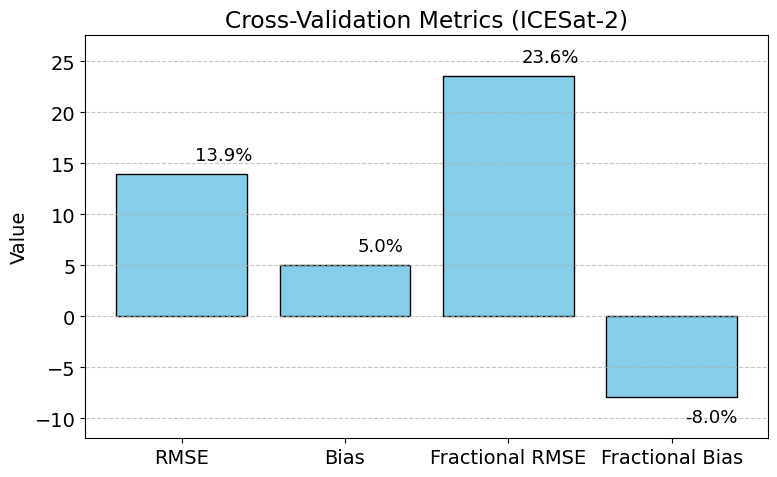

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Data to plot (overall metrics, not per-fold means/stdevs)
metrics = [
    "RMSE",
    "Bias",
    "Fractional RMSE",
    "Fractional Bias"
]

means = [
    overall_rmse,
    overall_bias,
    overall_frac_rmse,
    overall_frac_bias
]
means = np.array(means)*100

# Plotting
plt.figure(figsize=(8, 5))
x = np.arange(len(metrics))
bars = plt.bar(x, means, color='skyblue', edgecolor='black')

# Add labels offset slightly to the right of each bar
for bar, mean in zip(bars, means):
    height = bar.get_height()
    x_offset = bar.get_x() + bar.get_width() * 0.6  # shift label to the right
    y_offset = 1 * np.sign(height)
    plt.text(x_offset, height + y_offset, f"{mean:.1f}%",
             ha='left', va='bottom' if height >= 0 else 'top', fontsize=13)

plt.xticks(x, metrics)
plt.ylabel("Value")
plt.title("Cross-Validation Metrics (ICESat-2)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# --- Ensure y-axis has margin so labels don't get cut off ---
ymin = min(0, min(means)) -4
ymax = max(means) + 4 if max(means) > 0 else 1
plt.ylim(ymin, ymax)

plt.tight_layout()
# plt.savefig("poster_reclassified_probit_cv_metrics_overall.svg")
plt.show()



Camera-to-Fold Assignment:

Fold 1:
  - oregon_yp: 129 total (117 binary, 12 fractional)
  - queens: 11 total (11 binary, 0 fractional)
  >> Fold 1 Total: 140 points (128 binary, 12 fractional)

Fold 2:
  - old_jack_pine: 110 total (92 binary, 18 fractional)
  - tammela: 56 total (56 binary, 0 fractional)
  >> Fold 2 Total: 166 points (148 binary, 18 fractional)

Fold 3:
  - sodankyla_full: 88 total (87 binary, 1 fractional)
  - wslcreek: 22 total (20 binary, 2 fractional)
  - lacclair: 21 total (19 binary, 2 fractional)
  - bartlett: 9 total (6 binary, 3 fractional)
  >> Fold 3 Total: 140 points (132 binary, 8 fractional)

Fold 4:
  - kenttarova: 57 total (44 binary, 13 fractional)
  - varrio: 57 total (57 binary, 0 fractional)
  - willowcreek: 43 total (43 binary, 0 fractional)
  >> Fold 4 Total: 157 points (144 binary, 13 fractional)

Fold 5:
  - underc: 46 total (37 binary, 9 fractional)
  - hyytiala: 86 total (86 binary, 0 fractional)
  - underhill: 5 total (5 binary, 0 fractiona

/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encou

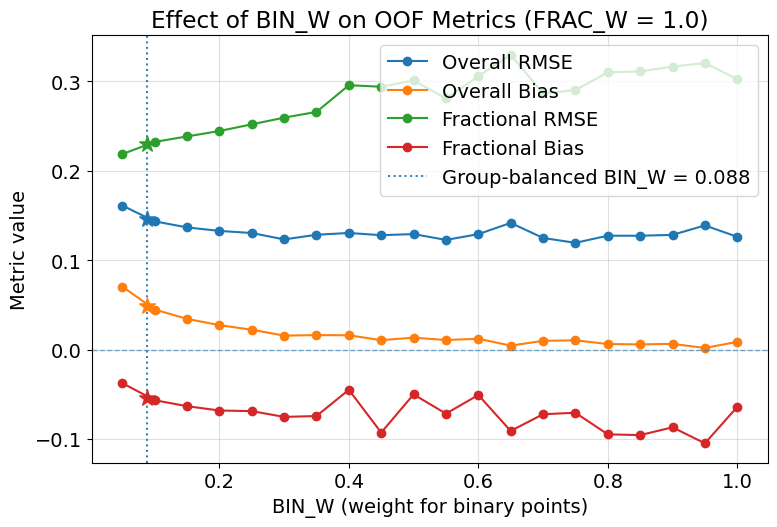

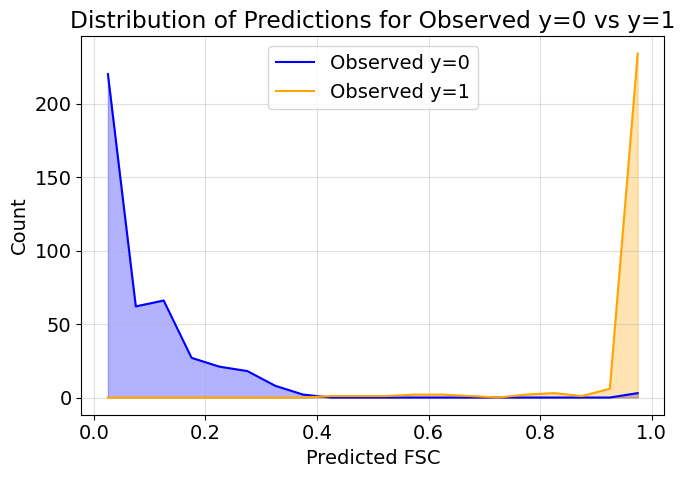

/tmp/ipykernel_2909147/2469894397.py:383: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(all_Eg_val_arr[m], all_Ev_val_arr[m],
/tmp/ipykernel_2909147/2469894397.py:413: UserWarning: Glyph 20 () missing from current font.
  plt.tight_layout()
/scratch/s1803229/.conda/envs/snow_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


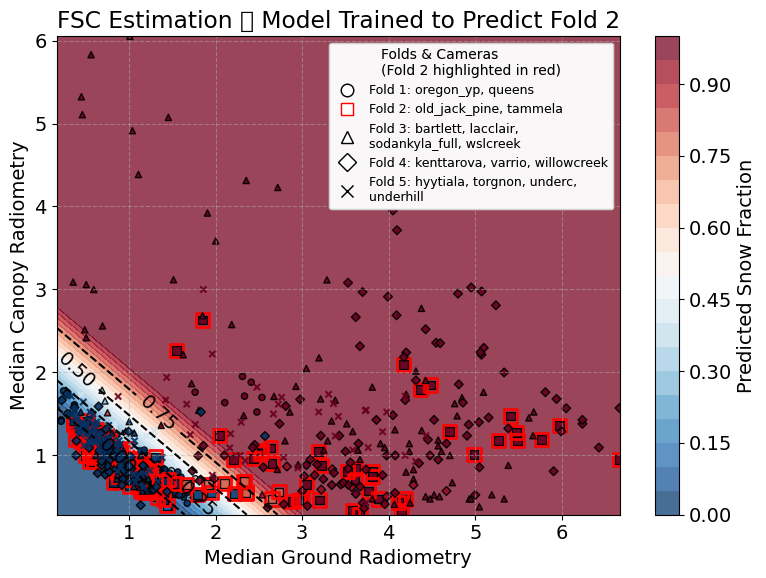

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, confusion_matrix
from scipy.optimize import minimize
from textwrap import fill

# ===========================
# Config / Weights
# ===========================
FRAC_W = 1.0   # keep fractional weight stabilized at 1.0
BIN_W  = 0.15  # default bin weight (used for the main CV run below)

# NEW: toggle to show only fractional (0<y<1) points overlaid on the contour
SHOW_FRACTIONAL_ONLY = False

def weighted_rmse(y_true, y_pred, frac_weight=FRAC_W, bin_weight=BIN_W):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    w = np.where((y_true > 0) & (y_true < 1), frac_weight, bin_weight)
    return np.sqrt(np.sum(w * (y_true - y_pred)**2) / np.sum(w))

# --- Piecewise linear mapping ---
def piecewise_map(z, a, b):
    z = np.asarray(z)
    result = np.zeros_like(z)
    result[z >= b] = 1
    mask = (z > a) & (z < b)
    result[mask] = (z[mask] - a) / (b - a)
    return result

def fsc_bin(val):
    if val < 0.05:
        return "[0,0.05)"
    elif val < 0.5:
        return "[0.05,0.5)"
    elif val < 0.95:
        return "[0.5,0.95)"
    else:
        return "[0.95,1]"

# --- Preprocessing ---
na_cols = ["Eg_strong", "Ev_strong", "pv", "pg", "pvpg", "JointSnowBinary", "date"]
if "camera" in frac_data.columns:
    na_cols.append("camera")

df = frac_data.dropna(subset=na_cols).copy()
combined = df.copy()

X_raw = combined[["Eg_strong", "Ev_strong"]].copy()
X = X_raw.copy()
X.insert(0, "const", 1)
y = combined["JointSnowBinary"].astype(float)
groups = combined["date"]
X_cols = X.columns

# --- Camera-balanced folds (as before) ---
assert "camera" in combined.columns, "camera column required for camera-based folds."

n_splits = 5
camera_groups = combined.groupby("camera")
sorted_cameras = sorted(
    camera_groups.groups.keys(),
    key=lambda cam: len(camera_groups.get_group(cam)),
    reverse=True
)

folds = [[] for _ in range(n_splits)]
fold_sample_counts = [0] * n_splits
fold_frac_counts = [0] * n_splits
camera_to_fold = {}

for cam in sorted_cameras:
    cam_data = camera_groups.get_group(cam)
    n = len(cam_data)
    has_fractional = ((cam_data["JointSnowBinary"] > 0) & (cam_data["JointSnowBinary"] < 1)).any()
    if has_fractional:
        idx = np.argmin(fold_frac_counts)
        folds[idx].extend(cam_data.index.tolist())
        fold_sample_counts[idx] += n
        fold_frac_counts[idx] += ((cam_data["JointSnowBinary"] > 0) & (cam_data["JointSnowBinary"] < 1)).sum()
        camera_to_fold[cam] = idx

for cam in sorted_cameras:
    if cam in camera_to_fold:
        continue
    cam_data = camera_groups.get_group(cam)
    n = len(cam_data)
    idx = np.argmin(fold_sample_counts)
    folds[idx].extend(cam_data.index.tolist())
    fold_sample_counts[idx] += n
    camera_to_fold[cam] = idx

group_markers = ['o', 's', '^', 'D', 'x'][:n_splits]
fold_to_cameras = {f: [] for f in range(n_splits)}
for cam, f in camera_to_fold.items():
    fold_to_cameras[f].append(cam)
row_fold_idx = combined['camera'].map(camera_to_fold)

print("\nCamera-to-Fold Assignment:")
for i in range(n_splits):
    fold_cams = [cam for cam, f in camera_to_fold.items() if f == i]
    total_bin = 0
    total_frac = 0
    print(f"\nFold {i+1}:")
    for cam in fold_cams:
        cam_data = camera_groups.get_group(cam)
        n_total = len(cam_data)
        n_frac = ((cam_data["JointSnowBinary"] > 0) & (cam_data["JointSnowBinary"] < 1)).sum()
        n_bin = n_total - n_frac
        total_bin += n_bin
        total_frac += n_frac
        print(f"  - {cam}: {n_total} total ({n_bin} binary, {n_frac} fractional)")
    print(f"  >> Fold {i+1} Total: {total_bin + total_frac} points ({total_bin} binary, {total_frac} fractional)")

merged_splits = []
all_indices = set(combined.index)
for i in range(n_splits):
    val_idx = folds[i]
    train_idx = list(all_indices - set(val_idx))
    merged_splits.append((train_idx, val_idx))

# --- Cross-validation (main run, uses FRAC_W=1 and BIN_W from top) ---
rmses, rmses_frac, biases, biases_frac, bin_accuracies = [], [], [], [], []
all_y_val, all_y_pred = [], []
all_Eg_val, all_Ev_val, all_yval_color = [], [], []
all_actual_bins, all_pred_bins = [], []

for train_idx, val_idx in merged_splits:
    X_tr = X.loc[train_idx].values
    y_tr = y.loc[train_idx].values
    X_val = X.loc[val_idx].values
    y_val = y.loc[val_idx]

    def objective(params):
        a, b = params[-2], params[-1]
        if b <= a:
            return np.inf
        beta = params[:-2]
        z = X_tr @ beta
        y_pred_tr = piecewise_map(z, a, b)
        return weighted_rmse(y_tr, y_pred_tr, frac_weight=FRAC_W, bin_weight=BIN_W)

    init_params = np.zeros(X_tr.shape[1] + 2)
    init_params[-2] = -1
    init_params[-1] = 1
    res = minimize(objective, init_params, method='L-BFGS-B')
    params = res.x
    beta, a, b = params[:-2], params[-2], params[-1]

    z_val = X_val @ beta
    y_pred = np.round(piecewise_map(z_val, a, b), 2)

    actual_bins = y_val.apply(fsc_bin)
    pred_bins = pd.Series(y_pred, index=y_val.index).apply(fsc_bin)
    bin_accuracies.append((actual_bins == pred_bins).mean())

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    bias = np.mean(y_pred - y_val)
    rmses.append(rmse); biases.append(bias)

    mask_frac = (y_val > 0) & (y_val < 1)
    if mask_frac.sum() > 0:
        rmses_frac.append(np.sqrt(mean_squared_error(y_val[mask_frac], y_pred[mask_frac])))
        biases_frac.append(np.mean(y_pred[mask_frac] - y_val[mask_frac]))

    all_y_val.extend(y_val.tolist()); all_y_pred.extend(y_pred.tolist())
    all_Eg_val.extend(X_raw.loc[val_idx, "Eg_strong"].tolist())
    all_Ev_val.extend(X_raw.loc[val_idx, "Ev_strong"].tolist())
    all_yval_color.extend(y_val.tolist())
    all_actual_bins.extend(actual_bins.tolist()); all_pred_bins.extend(pred_bins.tolist())

# === OVERALL metrics across ALL OOF predictions ===
all_y_val = np.array(all_y_val, dtype=float)
all_y_pred = np.array(all_y_pred, dtype=float)

overall_rmse = float(np.sqrt(mean_squared_error(all_y_val, all_y_pred)))
overall_bias = float(np.mean(all_y_pred - all_y_val))

mask_frac_all = (all_y_val > 0) & (all_y_val < 1)
overall_frac_rmse = float(np.sqrt(mean_squared_error(all_y_val[mask_frac_all], all_y_pred[mask_frac_all]))) if mask_frac_all.any() else np.nan
overall_frac_bias = float(np.mean(all_y_pred[mask_frac_all] - all_y_val[mask_frac_all])) if mask_frac_all.any() else np.nan

all_actual_bins = pd.Series(all_actual_bins)
all_pred_bins = pd.Series(all_pred_bins)
overall_bin_accuracy = float((all_actual_bins == all_pred_bins).mean())

# --- Final model on all data (weighted objective too) ---
X_all = X.values
y_all = y.values

def final_objective(params):
    a, b = params[-2], params[-1]
    if b <= a:
        return np.inf
    beta = params[:-2]
    z = X_all @ beta
    y_pred_all = piecewise_map(z, a, b)
    return weighted_rmse(y_all, y_pred_all, frac_weight=FRAC_W, bin_weight=BIN_W)

init_params = np.zeros(X_all.shape[1] + 2)
init_params[-2] = -1
init_params[-1] = 1
res_final = minimize(final_objective, init_params, method='L-BFGS-B')
params_final = res_final.x
beta_final, a_final, b_final = params_final[:-2], params_final[-2], params_final[-1]
print(f"\nFinal model a: {a_final:.4f}, b: {b_final:.4f}")
print("Final beta:", dict(zip(X_cols, beta_final)))

# --- Summary (same style as before) ---
print("\n=== Cross-Validation (OOF) Metrics Computed OVER ALL Predictions ===")
print(f"Overall RMSE: {overall_rmse:.4f}")
print(f"Overall Bias: {overall_bias:.4f}")
print(f"Overall Fractional RMSE: {overall_frac_rmse:.4f}")
print(f"Overall Fractional Bias: {overall_frac_bias:.4f}")
print(f"Overall Classification Accuracy (4-bin): {overall_bin_accuracy:.2%}")

# ============================================================
# NEW: BIN_W sweep (FRAC_W fixed at 1.0) + group-balanced mark
# ============================================================
def run_cv_metrics_for_binw(bin_w):
    """Run CV with a specific bin_weight; return OOF metrics."""
    all_y_val_local, all_y_pred_local = [], []
    for train_idx, val_idx in merged_splits:
        X_tr = X.loc[train_idx].values
        y_tr = y.loc[train_idx].values
        X_val = X.loc[val_idx].values
        y_val_local = y.loc[val_idx]

        def obj(p):
            a, b = p[-2], p[-1]
            if b <= a:
                return np.inf
            beta = p[:-2]
            z_tr = X_tr @ beta
            y_pred_tr = piecewise_map(z_tr, a, b)
            return weighted_rmse(y_tr, y_pred_tr, frac_weight=1.0, bin_weight=bin_w)

        init_p = np.zeros(X_tr.shape[1] + 2)
        init_p[-2] = -1
        init_p[-1] = 1
        res = minimize(obj, init_p, method='L-BFGS-B')
        beta, a, b = res.x[:-2], res.x[-2], res.x[-1]

        z_val = X_val @ beta
        y_pred_local = np.round(piecewise_map(z_val, a, b), 2)
        all_y_val_local.extend(y_val_local.tolist())
        all_y_pred_local.extend(y_pred_local.tolist())

    all_y_val_local = np.asarray(all_y_val_local, dtype=float)
    all_y_pred_local = np.asarray(all_y_pred_local, dtype=float)

    rmse = float(np.sqrt(mean_squared_error(all_y_val_local, all_y_pred_local)))
    bias = float(np.mean(all_y_pred_local - all_y_val_local))

    mfrac = (all_y_val_local > 0) & (all_y_val_local < 1)
    frmse = float(np.sqrt(mean_squared_error(all_y_val_local[mfrac], all_y_pred_local[mfrac]))) if mfrac.any() else np.nan
    fbias = float(np.mean(all_y_pred_local[mfrac] - all_y_val_local[mfrac])) if mfrac.any() else np.nan

    return dict(overall_rmse=rmse, overall_bias=bias, overall_frac_rmse=frmse, overall_frac_bias=fbias)

# 0.05 .. 1.0 inclusive
BIN_W_GRID = [i/20 for i in range(1, 21)]
n_frac_total = int(((y > 0) & (y < 1)).sum())
n_bin_total  = int(len(y) - n_frac_total)
BIN_W_GROUP  = (n_frac_total / n_bin_total) if n_bin_total > 0 else 1.0

grid_metrics = [run_cv_metrics_for_binw(bw) for bw in BIN_W_GRID]
rmse_vals  = [m["overall_rmse"]      for m in grid_metrics]
bias_vals  = [m["overall_bias"]      for m in grid_metrics]
frmse_vals = [m["overall_frac_rmse"] for m in grid_metrics]
fbias_vals = [m["overall_frac_bias"] for m in grid_metrics]

group_metrics = run_cv_metrics_for_binw(BIN_W_GROUP)

plt.figure(figsize=(8, 5.5))
l1, = plt.plot(BIN_W_GRID, rmse_vals,  marker='o', label='Overall RMSE')
l2, = plt.plot(BIN_W_GRID, bias_vals,  marker='o', label='Overall Bias')
l3, = plt.plot(BIN_W_GRID, frmse_vals, marker='o', label='Fractional RMSE')
l4, = plt.plot(BIN_W_GRID, fbias_vals, marker='o', label='Fractional Bias')
plt.axhline(0, linestyle='--', linewidth=1, alpha=0.6)
plt.axvline(BIN_W_GROUP, linestyle=':', linewidth=1.5, alpha=0.9,
            label=f'Group-balanced BIN_W = {BIN_W_GROUP:.3f}')
plt.scatter(BIN_W_GROUP, group_metrics["overall_rmse"],      s=140, marker='*', zorder=5, color=l1.get_color())
plt.scatter(BIN_W_GROUP, group_metrics["overall_bias"],      s=140, marker='*', zorder=5, color=l2.get_color())
plt.scatter(BIN_W_GROUP, group_metrics["overall_frac_rmse"], s=140, marker='*', zorder=5, color=l3.get_color())
plt.scatter(BIN_W_GROUP, group_metrics["overall_frac_bias"], s=140, marker='*', zorder=5, color=l4.get_color())
plt.xlabel("BIN_W (weight for binary points)")
plt.ylabel("Metric value")
plt.title("Effect of BIN_W on OOF Metrics (FRAC_W = 1.0)")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# NEW: Distribution of predictions for observed y=0 vs y=1
#       continuous line histograms with shaded fill (linear count)
# ============================================================
mask_y0 = all_y_val == 0
mask_y1 = all_y_val == 1
pred_y0 = all_y_pred[mask_y0]
pred_y1 = all_y_pred[mask_y1]

bin_edges = np.arange(0.0, 1.05, 0.05)
counts_y0, _ = np.histogram(pred_y0, bins=bin_edges)
counts_y1, _ = np.histogram(pred_y1, bins=bin_edges)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure(figsize=(7,5))
plt.plot(bin_centers, counts_y0, color='blue',   label='Observed y=0')
plt.fill_between(bin_centers, 0, counts_y0, color='blue', alpha=0.3)
plt.plot(bin_centers, counts_y1, color='orange', label='Observed y=1')
plt.fill_between(bin_centers, 0, counts_y1, color='orange', alpha=0.3)
plt.xlabel("Predicted FSC")
plt.ylabel("Count")
plt.title("Distribution of Predictions for Observed y=0 vs y=1")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# =========================
# === Styled Contour Plot ==
# =========================
first_fold = 1
all_indices = set(X.index)
first_val_idx = folds[first_fold]
first_train_idx = list(all_indices - set(first_val_idx))

X_tr_plot = X.loc[first_train_idx].values
y_tr_plot = y.loc[first_train_idx].values

def plot_objective(params):
    a, b = params[-2], params[-1]
    if b <= a:
        return np.inf
    beta = params[:-2]
    z = X_tr_plot @ beta
    y_pred_plot = piecewise_map(z, a, b)
    return weighted_rmse(y_tr_plot, y_pred_plot, frac_weight=FRAC_W, bin_weight=BIN_W)

init_params_plot = np.zeros(X_tr_plot.shape[1] + 2)
init_params_plot[-2] = -1
init_params_plot[-1] = 1
res_plot = minimize(plot_objective, init_params_plot, method='L-BFGS-B')
params_plot = res_plot.x
beta_plot, a_plot, b_plot = params_plot[:-2], params_plot[-2], params_plot[-1]

eg_vals = np.linspace(X_raw["Eg_strong"].min(), X_raw["Eg_strong"].max(), 300)
ev_vals = np.linspace(X_raw["Ev_strong"].min(), X_raw["Ev_strong"].max(), 300)
EG, EV = np.meshgrid(eg_vals, ev_vals)

grid_df = pd.DataFrame({"const": 1, "Eg_strong": EG.ravel(), "Ev_strong": EV.ravel()})
z_grid = grid_df.values @ beta_plot
Z = piecewise_map(z_grid, a_plot, b_plot).reshape(EG.shape)

# Build folds order to match OOF concatenation
all_point_folds = []
for _, val_idx in merged_splits:
    all_point_folds.extend(row_fold_idx.loc[val_idx].values)
all_point_folds = np.array(all_point_folds)

all_Eg_val_arr = np.asarray(all_Eg_val)
all_Ev_val_arr = np.asarray(all_Ev_val)
all_yval_color_arr = np.asarray(all_yval_color, dtype=float)

# NEW: fractional-only mask for overlay + fixed color scale
frac_mask_all = ((all_yval_color_arr > 0) & (all_yval_color_arr < 1)) if SHOW_FRACTIONAL_ONLY else np.ones_like(all_yval_color_arr, dtype=bool)

fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(EG, EV, Z, levels=np.linspace(0, 1, 21), cmap='RdBu_r', alpha=0.75)
cbar = fig.colorbar(contour, ax=ax); cbar.set_label('Predicted Snow Fraction')

lines = ax.contour(EG, EV, Z, levels=[0, 0.25, 0.5, 0.75, 1], colors='k', linestyles='--')
ax.clabel(lines, fmt='%1.2f')

for f in range(n_splits):
    m = (all_point_folds == f) & frac_mask_all
    if not np.any(m):
        continue
    base_size = 20 if f != first_fold else 40
    ax.scatter(all_Eg_val_arr[m], all_Ev_val_arr[m],
               c=all_yval_color_arr[m], cmap='RdBu_r', vmin=0, vmax=1,  # stabilize color normalization
               edgecolor='k', s=base_size, marker=group_markers[f], alpha=0.9)
    if f == first_fold and np.any(m):
        ax.scatter(all_Eg_val_arr[m], all_Ev_val_arr[m],
                   facecolors='none', edgecolors='red',
                   linewidths=2.0, marker=group_markers[f], s=90, alpha=0.95)

# Legend with cameras per fold
fold_handles, fold_labels = [], []
wrap_width = 40
for f in range(n_splits):
    handle = plt.Line2D([0], [0], marker=group_markers[f], linestyle='',
                        markerfacecolor='white',
                        markeredgecolor=('red' if f == first_fold else 'k'),
                        markersize=9, linewidth=2)
    cams = sorted(fold_to_cameras.get(f, []))
    label = f"Fold {f+1}: " + (", ".join(cams) if cams else "(no cameras)")
    fold_handles.append(handle)
    fold_labels.append(fill(label, width=wrap_width))

fold_legend = ax.legend(fold_handles, fold_labels,
                        title='Folds & Cameras\n(Fold 2 highlighted in red)',
                        loc='upper right', frameon=True, fontsize=9, title_fontsize=10)
ax.add_artist(fold_legend)

ax.set_xlabel("Median Ground Radiometry")
ax.set_ylabel("Median Canopy Radiometry")
ax.set_title("FSC Estimation  Model Trained to Predict Fold 2")
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


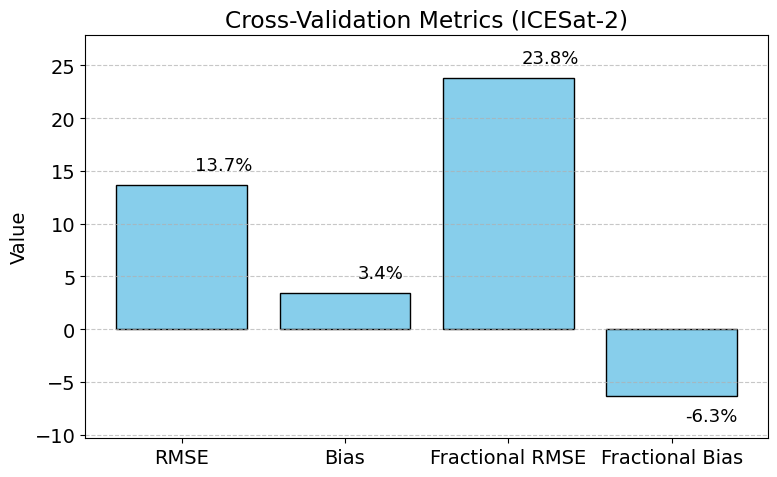

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Data to plot (overall metrics, not per-fold means/stdevs)
metrics = [
    "RMSE",
    "Bias",
    "Fractional RMSE",
    "Fractional Bias"
]

means = [
    overall_rmse,
    overall_bias,
    overall_frac_rmse,
    overall_frac_bias
]
means = np.array(means)*100

# Plotting
plt.figure(figsize=(8, 5))
x = np.arange(len(metrics))
bars = plt.bar(x, means, color='skyblue', edgecolor='black')

# Add labels offset slightly to the right of each bar
for bar, mean in zip(bars, means):
    height = bar.get_height()
    x_offset = bar.get_x() + bar.get_width() * 0.6  # shift label to the right
    y_offset = 1 * np.sign(height)
    plt.text(x_offset, height + y_offset, f"{mean:.1f}%",
             ha='left', va='bottom' if height >= 0 else 'top', fontsize=13)

plt.xticks(x, metrics)
plt.ylabel("Value")
plt.title("Cross-Validation Metrics (ICESat-2)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# --- Ensure y-axis has margin so labels don't get cut off ---
ymin = min(0, min(means)) -4
ymax = max(means) + 4 if max(means) > 0 else 1
plt.ylim(ymin, ymax)

plt.tight_layout()
# plt.savefig("poster_reclassified_probit_cv_metrics_overall.svg")
plt.show()



Camera-to-Fold Assignment:

Fold 1:
  - oregon_yp: 129 total (117 binary, 12 fractional)
  - queens: 11 total (11 binary, 0 fractional)
  >> Fold 1 Total: 140 points (128 binary, 12 fractional)

Fold 2:
  - old_jack_pine: 110 total (92 binary, 18 fractional)
  - tammela: 56 total (56 binary, 0 fractional)
  >> Fold 2 Total: 166 points (148 binary, 18 fractional)

Fold 3:
  - sodankyla_full: 88 total (87 binary, 1 fractional)
  - wslcreek: 22 total (20 binary, 2 fractional)
  - lacclair: 21 total (19 binary, 2 fractional)
  - bartlett: 9 total (6 binary, 3 fractional)
  >> Fold 3 Total: 140 points (132 binary, 8 fractional)

Fold 4:
  - kenttarova: 57 total (44 binary, 13 fractional)
  - varrio: 57 total (57 binary, 0 fractional)
  - willowcreek: 43 total (43 binary, 0 fractional)
  >> Fold 4 Total: 157 points (144 binary, 13 fractional)

Fold 5:
  - underc: 46 total (37 binary, 9 fractional)
  - hyytiala: 86 total (86 binary, 0 fractional)
  - underhill: 5 total (5 binary, 0 fractiona

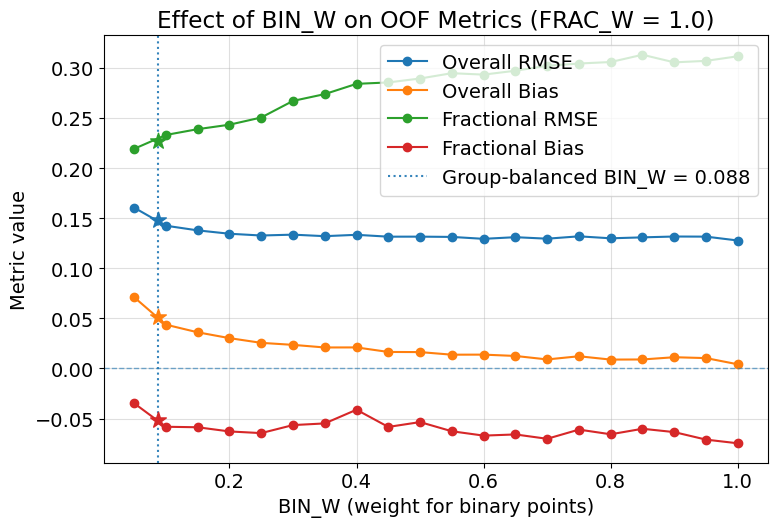

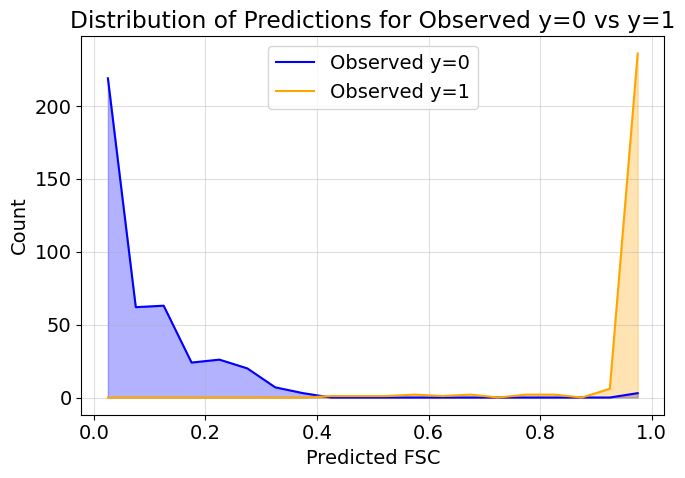

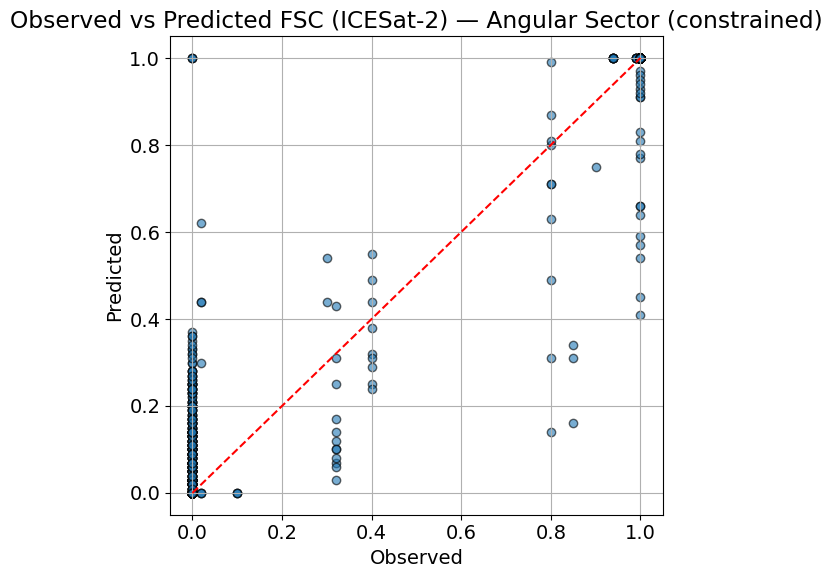

/tmp/ipykernel_2909147/2483188090.py:480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(all_Eg_val_arr[m], all_Ev_val_arr[m],
/tmp/ipykernel_2909147/2483188090.py:476: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(all_Eg_val_arr[m], all_Ev_val_arr[m],


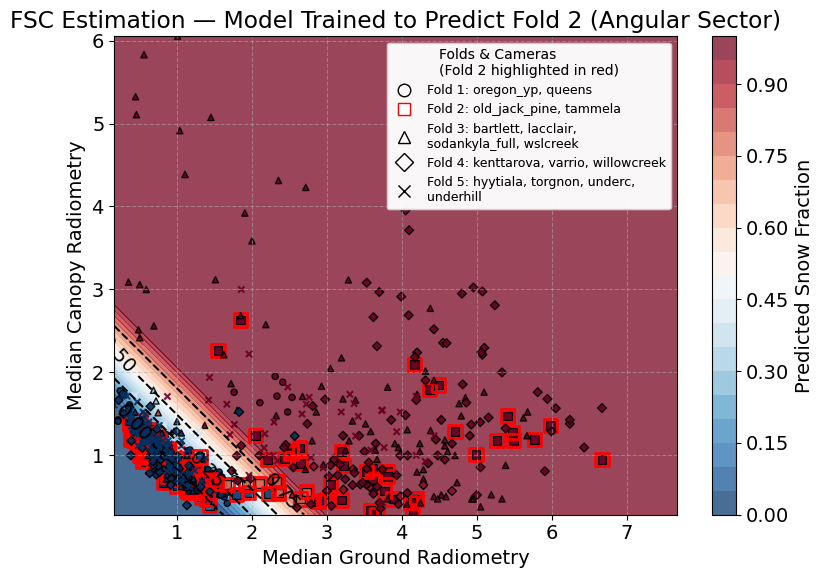

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, confusion_matrix
from scipy.optimize import minimize
from textwrap import fill

# ------------------------------ config (new) ------------------------------
SHOW_FRACTIONAL_ONLY = False  # set True to show only fractional points on the contour plot


# ------------------------------ helpers ------------------------------
def mod2pi(x):
    return np.mod(x, 2*np.pi)

def dccw(a, b):
    """Counter-clockwise angular distance from a to b, both in [0, 2π)."""
    return mod2pi(b - a)

def fsc_bin(val):
    if val < 0.05:
        return "[0,0.05)"
    elif val < 0.5:
        return "[0.05,0.5)"
    elif val < 0.95:
        return "[0.5,0.95)"
    else:
        return "[0.95,1]"

def weighted_rmse(y_true, y_pred, frac_weight=1.0, bin_weight=0.25):
    """Heavily weight fractional points (0<y<1), lightly weight binary (0/1)."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    w = np.where((y_true > 0) & (y_true < 1), frac_weight, bin_weight)
    return np.sqrt(np.sum(w * (y_true - y_pred) ** 2) / np.sum(w))

def angular_sector_map(eg, ev, cx, cy, theta1, theta2, eps=1e-9):
    """
    Sector model:
      - value=0 at theta1, value=1 at theta2 along CCW arc (linear ramp)
      - clockwise of theta1 -> 0; counterclockwise of theta2 (up to pi) -> 1
      - at theta0 = pi -> 0 (jump)
      - center point -> 0
    """
    eg = np.asarray(eg); ev = np.asarray(ev)
    theta = mod2pi(np.arctan2(ev - cy, eg - cx))
    t1 = mod2pi(theta1)
    t2 = mod2pi(theta2)
    pi_m = mod2pi(np.pi)

    arc = dccw(t1, t2)
    arc = np.maximum(arc, eps)

    d1 = dccw(t1, theta)

    in_grad = d1 <= arc + eps
    vals = np.empty_like(theta, dtype=float)
    vals[in_grad] = np.clip(d1[in_grad] / arc, 0.0, 1.0)

    d_from_t2 = dccw(t2, theta)
    d_t2_to_pi = dccw(t2, pi_m)

    in_high = (~in_grad) & (d_from_t2 < d_t2_to_pi - eps)
    vals[in_high] = 1.0
    vals[~(in_grad | in_high)] = 0.0

    at_pi = np.isclose(mod2pi(theta), pi_m, atol=1e-12)
    vals[at_pi] = 0.0

    at_center = np.isclose(eg, cx, atol=1e-12) & np.isclose(ev, cy, atol=1e-12)
    vals[at_center] = 0.0
    return vals

def tiny_arc_penalty(theta1, theta2, thresh=1e-3):
    arc = dccw(mod2pi(theta1), mod2pi(theta2))
    if arc < thresh:
        return 1e6 * (thresh - arc + 1e-9)
    return 0.0

# ------------------------------ data ------------------------------
# include camera so we can split by camera
df = frac_data.dropna(subset=["Eg_strong","Ev_strong","pv","pg","pvpg","JointSnowBinary","date","camera"]).copy()
combined = df.copy()

X_raw = combined[["Eg_strong","Ev_strong"]].copy()
eg_all = X_raw["Eg_strong"].values
ev_all = X_raw["Ev_strong"].values
y = combined["JointSnowBinary"].astype(float)

# ==============================
# Camera-based folds (balanced)
# ==============================
n_splits = 5
camera_groups = combined.groupby("camera")
sorted_cameras = sorted(
    camera_groups.groups.keys(),
    key=lambda cam: len(camera_groups.get_group(cam)),
    reverse=True
)

folds = [[] for _ in range(n_splits)]
fold_sample_counts = [0] * n_splits
fold_frac_counts = [0] * n_splits
camera_to_fold = {}

# Assign cameras with fractional data first
for cam in sorted_cameras:
    cam_data = camera_groups.get_group(cam)
    n = len(cam_data)
    has_fractional = ((cam_data["JointSnowBinary"] > 0) & (cam_data["JointSnowBinary"] < 1)).any()
    if has_fractional:
        idx = np.argmin(fold_frac_counts)
        folds[idx].extend(cam_data.index.tolist())
        fold_sample_counts[idx] += n
        fold_frac_counts[idx] += ((cam_data["JointSnowBinary"] > 0) & (cam_data["JointSnowBinary"] < 1)).sum()
        camera_to_fold[cam] = idx

# Assign remaining cameras (no fractional data)
for cam in sorted_cameras:
    if cam in camera_to_fold:
        continue
    cam_data = camera_groups.get_group(cam)
    n = len(cam_data)
    idx = np.argmin(fold_sample_counts)
    folds[idx].extend(cam_data.index.tolist())
    fold_sample_counts[idx] += n
    camera_to_fold[cam] = idx

# --- Fold display prep ---
group_markers = ['o', 's', '^', 'D', 'x'][:n_splits]
fold_to_cameras = {f: [] for f in range(n_splits)}
for cam, f in camera_to_fold.items():
    fold_to_cameras[f].append(cam)
row_fold_idx = combined['camera'].map(camera_to_fold)

# --- Diagnostics (optional) ---
print("\nCamera-to-Fold Assignment:")
for i in range(n_splits):
    fold_cams = [cam for cam, f in camera_to_fold.items() if f == i]
    total_bin = total_frac = 0
    print(f"\nFold {i+1}:")
    for cam in fold_cams:
        cam_data = camera_groups.get_group(cam)
        n_total = len(cam_data)
        n_frac = ((cam_data["JointSnowBinary"] > 0) & (cam_data["JointSnowBinary"] < 1)).sum()
        n_bin = n_total - n_frac
        total_bin += n_bin
        total_frac += n_frac
        print(f"  - {cam}: {n_total} total ({n_bin} binary, {n_frac} fractional)")
    print(f"  >> Fold {i+1} Total: {total_bin + total_frac} points ({total_bin} binary, {total_frac} fractional)")

# Create list of splits (train_idx, val_idx)
merged_splits = []
all_indices = set(combined.index)
for i in range(n_splits):
    val_idx = folds[i]
    train_idx = list(all_indices - set(val_idx))
    merged_splits.append((train_idx, val_idx))

# ------------------------------ optimization setup ------------------------------
# Bounds for parameters to enforce:
#   cx <= 0, cy > 0, theta1 >= -pi/2, theta2 <= 0
eg_min, eg_max = float(X_raw["Eg_strong"].min()), float(X_raw["Eg_strong"].max())
ev_min, ev_max = float(X_raw["Ev_strong"].min()), float(X_raw["Ev_strong"].max())
margin_eg = max(0.5, 0.05*(eg_max-eg_min))
margin_ev = max(0.5, 0.05*(ev_max-ev_min))

def init_params():
    # start from your usual guess (cx=0, cy=1.8, t1=-pi/4, t2=-pi/8)
    return np.array([0.0, 1.8, -np.pi/4, -np.pi/8], dtype=float)

bounds = [
    (-np.inf, 0.0),              # cx  <= 0
    (max(1e-6, 0.0), np.inf),   # cy  > 0 (approx via lower bound)
    (-np.pi/2, np.pi),                      # theta1 >= -pi/2
    (-np.pi, 0.0),                          # theta2 <= 0
]

# weights
FRAC_W = 1.0
n_frac_total = int(((y > 0) & (y < 1)).sum())
n_bin_total  = int(len(y) - n_frac_total)
# BIN_W  = (n_frac_total / n_bin_total) if n_bin_total > 0 else 1.0
BIN_W = 0.15

# ------------------------------ cross-validation ------------------------------
rmses, rmses_frac, biases, biases_frac, bin_accuracies = [], [], [], [], []
all_y_val, all_y_pred = [], []
all_Eg_val, all_Ev_val, all_yval_color = [], [], []
all_actual_bins, all_pred_bins = [], []

for train_idx, val_idx in merged_splits:
    y_tr  = y.loc[train_idx].values
    y_val_s = y.loc[val_idx]
    eg_tr = X_raw.loc[train_idx, "Eg_strong"].values
    ev_tr = X_raw.loc[train_idx, "Ev_strong"].values
    eg_val = X_raw.loc[val_idx, "Eg_strong"].values
    ev_val = X_raw.loc[val_idx, "Ev_strong"].values

    def objective(p):
        cx, cy, t1, t2 = p
        y_hat = angular_sector_map(eg_tr, ev_tr, cx, cy, t1, t2)
        return weighted_rmse(y_tr, y_hat, frac_weight=FRAC_W, bin_weight=BIN_W) + tiny_arc_penalty(t1, t2)

    res = minimize(objective, init_params(), method="L-BFGS-B", bounds=bounds)
    cx, cy, t1, t2 = res.x

    y_pred = np.round(angular_sector_map(eg_val, ev_val, cx, cy, t1, t2), 2)

    actual_bins = y_val_s.apply(fsc_bin)
    pred_bins = pd.Series(y_pred, index=y_val_s.index).apply(fsc_bin)
    bin_accuracies.append((actual_bins == pred_bins).mean())

    rmse = np.sqrt(mean_squared_error(y_val_s, y_pred))
    bias = np.mean(y_pred - y_val_s)
    rmses.append(rmse); biases.append(bias)

    mask_frac = (y_val_s > 0) & (y_val_s < 1)
    if mask_frac.sum() > 0:
        rmses_frac.append(np.sqrt(mean_squared_error(y_val_s[mask_frac], y_pred[mask_frac])))
        biases_frac.append(np.mean(y_pred[mask_frac] - y_val_s[mask_frac]))

    all_y_val.extend(y_val_s.tolist()); all_y_pred.extend(y_pred.tolist())
    all_Eg_val.extend(eg_val.tolist());  all_Ev_val.extend(ev_val.tolist())
    all_yval_color.extend(y_val_s.tolist())
    all_actual_bins.extend(actual_bins.tolist()); all_pred_bins.extend(pred_bins.tolist())

# ------------------------------ OOF metrics ------------------------------
all_y_val = np.array(all_y_val, dtype=float)
all_y_pred = np.array(all_y_pred, dtype=float)

overall_rmse = float(np.sqrt(mean_squared_error(all_y_val, all_y_pred)))
overall_bias = float(np.mean(all_y_pred - all_y_val))

mask_frac_all = (all_y_val > 0) & (all_y_val < 1)
overall_frac_rmse = float(np.sqrt(mean_squared_error(all_y_val[mask_frac_all], all_y_pred[mask_frac_all]))) if mask_frac_all.any() else np.nan
overall_frac_bias = float(np.mean(all_y_pred[mask_frac_all] - all_y_val[mask_frac_all])) if mask_frac_all.any() else np.nan

all_actual_bins = pd.Series(all_actual_bins)
all_pred_bins = pd.Series(all_pred_bins)
overall_bin_accuracy = float((all_actual_bins == all_pred_bins).mean())

# ------------------------------ final fit on all data (for reporting) ------------------------------
def final_objective(p):
    cx, cy, t1, t2 = p
    y_hat = angular_sector_map(eg_all, ev_all, cx, cy, t1, t2)
    return weighted_rmse(y.values, y_hat, frac_weight=FRAC_W, bin_weight=BIN_W) + tiny_arc_penalty(t1, t2)

res_final = minimize(final_objective, init_params(), method="L-BFGS-B", bounds=bounds)
cx_f, cy_f, t1_f, t2_f = res_final.x
print("\nFinal angular-sector model parameters (with constraints):")
print(f"  center (cx, cy): ({cx_f:.4f}, {cy_f:.4f})   [cx<=0, cy>0]")
print(f"  theta_1 (rad):   {t1_f:.6f}   [>= -pi/2] -> value 0")
print(f"  theta_2 (rad):   {t2_f:.6f}   [<= 0]     -> value 1")
print("  ramp is along CCW arc from theta_1 to theta_2; outside, clip as specified; value at theta=pi is 0.")

# ------------------------------ summary ------------------------------
print("\n=== Cross-Validation (OOF) Metrics OVER ALL Predictions ===")
print(f"Overall RMSE: {overall_rmse:.4f}")
print(f"Overall Bias: {overall_bias:.4f}")
print(f"Overall Fractional RMSE: {overall_frac_rmse:.4f}")
print(f"Overall Fractional Bias: {overall_frac_bias:.4f}")
print(f"Overall Classification Accuracy (4-bin): {overall_bin_accuracy:.2%}")




# ================================
# BIN_W sweep (FRAC_W fixed at 1.0)
# ================================
FRAC_W = 1.0  # ensure fractional weight is stabilized

def run_cv_metrics_for_binw(bin_w):
    """Run the existing CV with a specific bin_weight and return OOF metrics."""
    all_y_val_local, all_y_pred_local = [], []

    for train_idx, val_idx in merged_splits:
        y_tr  = y.loc[train_idx].values
        y_val_s = y.loc[val_idx]
        eg_tr = X_raw.loc[train_idx, "Eg_strong"].values
        ev_tr = X_raw.loc[train_idx, "Ev_strong"].values
        eg_val = X_raw.loc[val_idx, "Eg_strong"].values
        ev_val = X_raw.loc[val_idx, "Ev_strong"].values

        def objective(p):
            cx, cy, t1, t2 = p
            y_hat = angular_sector_map(eg_tr, ev_tr, cx, cy, t1, t2)
            return weighted_rmse(y_tr, y_hat, frac_weight=FRAC_W, bin_weight=bin_w) + tiny_arc_penalty(t1, t2)

        res = minimize(objective, init_params(), method="L-BFGS-B", bounds=bounds)
        cx, cy, t1, t2 = res.x

        y_pred = np.round(angular_sector_map(eg_val, ev_val, cx, cy, t1, t2), 2)
        all_y_val_local.extend(y_val_s.tolist())
        all_y_pred_local.extend(y_pred.tolist())

    all_y_val_local = np.asarray(all_y_val_local, dtype=float)
    all_y_pred_local = np.asarray(all_y_pred_local, dtype=float)

    overall_rmse = float(np.sqrt(mean_squared_error(all_y_val_local, all_y_pred_local)))
    overall_bias = float(np.mean(all_y_pred_local - all_y_val_local))

    mask_frac = (all_y_val_local > 0) & (all_y_val_local < 1)
    overall_frac_rmse = float(np.sqrt(mean_squared_error(all_y_val_local[mask_frac], all_y_pred_local[mask_frac]))) if mask_frac.any() else np.nan
    overall_frac_bias = float(np.mean(all_y_pred_local[mask_frac] - all_y_val_local[mask_frac])) if mask_frac.any() else np.nan

    return dict(
        overall_rmse=overall_rmse,
        overall_bias=overall_bias,
        overall_frac_rmse=overall_frac_rmse,
        overall_frac_bias=overall_frac_bias
    )

# grid 0.05 .. 1.0 (inclusive)
BIN_W_GRID = [i/20 for i in range(1, 21)]  # 0.05, 0.10, ..., 1.0

# group-balanced BIN_W = (# fractional points) / (# binary points)
n_frac_total = int(((y > 0) & (y < 1)).sum())
n_bin_total  = int(len(y) - n_frac_total)
BIN_W_GROUP  = (n_frac_total / n_bin_total) if n_bin_total > 0 else 1.0

# Evaluate metrics over the grid
grid_metrics = [run_cv_metrics_for_binw(bw) for bw in BIN_W_GRID]
rmse_vals  = [m["overall_rmse"]      for m in grid_metrics]
bias_vals  = [m["overall_bias"]      for m in grid_metrics]
frmse_vals = [m["overall_frac_rmse"] for m in grid_metrics]
fbias_vals = [m["overall_frac_bias"] for m in grid_metrics]

# Evaluate the group-balanced weight as well
group_metrics = run_cv_metrics_for_binw(BIN_W_GROUP)

# Single plot with four lines + vertical marker for group-balanced BIN_W
plt.figure(figsize=(8, 5.5))
l1, = plt.plot(BIN_W_GRID, rmse_vals,  marker='o', label='Overall RMSE')
l2, = plt.plot(BIN_W_GRID, bias_vals,  marker='o', label='Overall Bias')
l3, = plt.plot(BIN_W_GRID, frmse_vals, marker='o', label='Fractional RMSE')
l4, = plt.plot(BIN_W_GRID, fbias_vals, marker='o', label='Fractional Bias')

# visual anchors
plt.axhline(0, linestyle='--', linewidth=1, alpha=0.6)
plt.axvline(BIN_W_GROUP, linestyle=':', linewidth=1.5, alpha=0.9,
            label=f'Group-balanced BIN_W = {BIN_W_GROUP:.3f}')

# star markers at the group-balanced result (same colors as lines)
plt.scatter(BIN_W_GROUP, group_metrics["overall_rmse"],      s=140, marker='*', zorder=5, color=l1.get_color())
plt.scatter(BIN_W_GROUP, group_metrics["overall_bias"],      s=140, marker='*', zorder=5, color=l2.get_color())
plt.scatter(BIN_W_GROUP, group_metrics["overall_frac_rmse"], s=140, marker='*', zorder=5, color=l3.get_color())
plt.scatter(BIN_W_GROUP, group_metrics["overall_frac_bias"], s=140, marker='*', zorder=5, color=l4.get_color())

plt.xlabel("BIN_W (weight for binary points)")
plt.ylabel("Metric value")
plt.title("Effect of BIN_W on OOF Metrics (FRAC_W = 1.0)")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()








# ================================
# Distribution of predictions for y=0 vs y=1
# ================================
mask_y0 = all_y_val == 0
mask_y1 = all_y_val == 1

pred_y0 = all_y_pred[mask_y0]
pred_y1 = all_y_pred[mask_y1]

# Define consistent bins
bin_edges = np.arange(0.0, 1.05, 0.05)  # 0.0–1.0 in steps of 0.05

# Compute histograms
counts_y0, _ = np.histogram(pred_y0, bins=bin_edges)
counts_y1, _ = np.histogram(pred_y1, bins=bin_edges)

# Bin centers for plotting as line
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure(figsize=(7,5))

# Plot y=0
plt.plot(bin_centers, counts_y0, color='blue', label='Observed y=0')
plt.fill_between(bin_centers, 0, counts_y0, color='blue', alpha=0.3)

# Plot y=1
plt.plot(bin_centers, counts_y1, color='orange', label='Observed y=1')
plt.fill_between(bin_centers, 0, counts_y1, color='orange', alpha=0.3)

plt.xlabel("Predicted FSC")
plt.ylabel("Count")
plt.title("Distribution of Predictions for Observed y=0 vs y=1")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()









# ------------------------------ plotting ------------------------------
# 1) Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(all_y_val, all_y_pred, alpha=0.6, edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Observed vs Predicted FSC (ICESat-2) — Angular Sector (constrained)")
plt.grid(True)
plt.tight_layout()
plt.show()

# =========================
# 2) Styled Contour Plot
# =========================
# Train the plotting model on "all EXCEPT Fold 2" (index 1), mirroring your first script
first_fold = 1
all_idx_set = set(X_raw.index)
first_val_idx = folds[first_fold]
first_train_idx = list(all_idx_set - set(first_val_idx))

eg_tr_plot = X_raw.loc[first_train_idx, "Eg_strong"].values
ev_tr_plot = X_raw.loc[first_train_idx, "Ev_strong"].values
y_tr_plot  = y.loc[first_train_idx].values

def plot_objective(p):
    cx, cy, t1, t2 = p
    y_hat = angular_sector_map(eg_tr_plot, ev_tr_plot, cx, cy, t1, t2)
    return weighted_rmse(y_tr_plot, y_hat, frac_weight=FRAC_W, bin_weight=BIN_W) + tiny_arc_penalty(t1, t2)

res_plot = minimize(plot_objective, init_params(), method="L-BFGS-B", bounds=bounds)
cx_p, cy_p, t1_p, t2_p = res_plot.x

# Prediction grid using plotting model
eg_vals = np.linspace(X_raw["Eg_strong"].min(), X_raw["Eg_strong"].max()+1, 300)
ev_vals = np.linspace(X_raw["Ev_strong"].min(), X_raw["Ev_strong"].max(), 300)
EG, EV = np.meshgrid(eg_vals, ev_vals)
Z = angular_sector_map(EG, EV, cx_p, cy_p, t1_p, t2_p)

# Build folds for the OOF points in the same order all_* arrays were appended
all_point_folds = []
for _, val_idx in merged_splits:
    all_point_folds.extend(row_fold_idx.loc[val_idx].values)
all_point_folds = np.array(all_point_folds)

all_Eg_val_arr = np.asarray(all_Eg_val)
all_Ev_val_arr = np.asarray(all_Ev_val)
all_yval_color_arr = np.asarray(all_yval_color, dtype=float)

# NEW: optional fractional-only mask for the overlay points
frac_mask_all = ((all_yval_color_arr > 0) & (all_yval_color_arr < 1)) if SHOW_FRACTIONAL_ONLY else np.ones_like(all_yval_color_arr, dtype=bool)

# Plot — same style as your first script
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(EG, EV, Z, levels=np.linspace(0, 1, 21), cmap='RdBu_r', alpha=0.75)
cbar = fig.colorbar(contour, ax=ax); cbar.set_label('Predicted Snow Fraction')

lines = ax.contour(EG, EV, Z, levels=[0, 0.25, 0.5, 0.75, 1], colors='k', linestyles='--')
ax.clabel(lines, fmt='%1.2f')

# Per-fold markers with Fold 2 highlighted in red
for f in range(n_splits):
    m = (all_point_folds == f) & frac_mask_all   # <- minimal change
    if not np.any(m):
        continue
    base_size = 20 if f != first_fold else 40
    ax.scatter(all_Eg_val_arr[m], all_Ev_val_arr[m],
               c=all_yval_color_arr[m], cmap='RdBu_r',
               edgecolor='k', s=base_size, marker=group_markers[f], alpha=0.9, vmin=0, vmax=1)
    if f == first_fold and np.any(m):
        ax.scatter(all_Eg_val_arr[m], all_Ev_val_arr[m],
                   facecolors='none', edgecolors='red',
                   linewidths=2.0, marker=group_markers[f], s=90, alpha=0.95, vmin=0, vmax=1)


# Legend with cameras per fold
fold_handles, fold_labels = [], []
wrap_width = 40
for f in range(n_splits):
    handle = plt.Line2D([0], [0], marker=group_markers[f], linestyle='',
                        markerfacecolor='white',
                        markeredgecolor=('red' if f == first_fold else 'k'),
                        markersize=9, linewidth=2)
    cams = sorted(fold_to_cameras.get(f, []))
    label = f"Fold {f+1}: " + (", ".join(cams) if cams else "(no cameras)")
    fold_handles.append(handle)
    fold_labels.append(fill(label, width=wrap_width))

fold_legend = ax.legend(fold_handles, fold_labels,
                        title='Folds & Cameras\n(Fold 2 highlighted in red)',
                        loc='upper right', frameon=True, fontsize=9, title_fontsize=10)
ax.add_artist(fold_legend)

ax.set_xlabel("Median Ground Radiometry")
ax.set_ylabel("Median Canopy Radiometry")
ax.set_title("FSC Estimation — Model Trained to Predict Fold 2 (Angular Sector)")
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


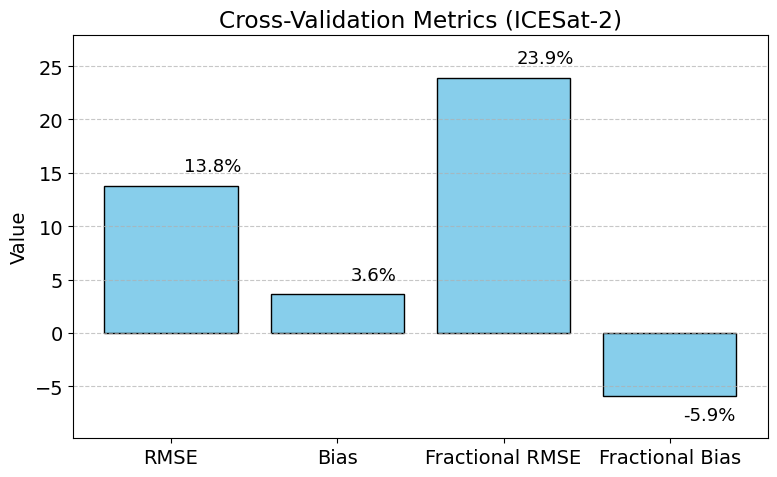

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Data to plot (overall metrics, not per-fold means/stdevs)
metrics = [
    "RMSE",
    "Bias",
    "Fractional RMSE",
    "Fractional Bias"
]

means = [
    overall_rmse,
    overall_bias,
    overall_frac_rmse,
    overall_frac_bias
]
means = np.array(means)*100

# Plotting
plt.figure(figsize=(8, 5))
x = np.arange(len(metrics))
bars = plt.bar(x, means, color='skyblue', edgecolor='black')

# Add labels offset slightly to the right of each bar
for bar, mean in zip(bars, means):
    height = bar.get_height()
    x_offset = bar.get_x() + bar.get_width() * 0.6  # shift label to the right
    y_offset = 1 * np.sign(height)
    plt.text(x_offset, height + y_offset, f"{mean:.1f}%",
             ha='left', va='bottom' if height >= 0 else 'top', fontsize=13)

plt.xticks(x, metrics)
plt.ylabel("Value")
plt.title("Cross-Validation Metrics (ICESat-2)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# --- Ensure y-axis has margin so labels don't get cut off ---
ymin = min(0, min(means)) -4
ymax = max(means) + 4 if max(means) > 0 else 1
plt.ylim(ymin, ymax)

plt.tight_layout()
# plt.savefig("poster_reclassified_probit_cv_metrics_overall.svg")
plt.show()


### Test Set

Fitted parameters: {'cx': -19.805891065374702, 'cy': 18.898914188343298, 'theta1': -0.7145498344846363, 'theta2': -0.6798929012808994, 'eg_min': 0.16228070175438597, 'eg_max': 6.666666666666667, 'ev_min': 0.2857142857142857, 'ev_max': 6.050420168067228}

=== Test Metrics ===
Overall RMSE:           0.1135
Overall Bias:           -0.0041
Fractional RMSE:        0.2410
Fractional Bias:        -0.0531


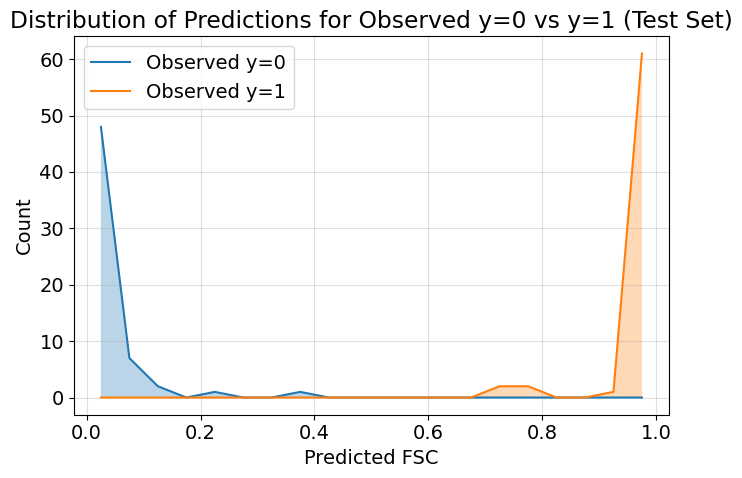

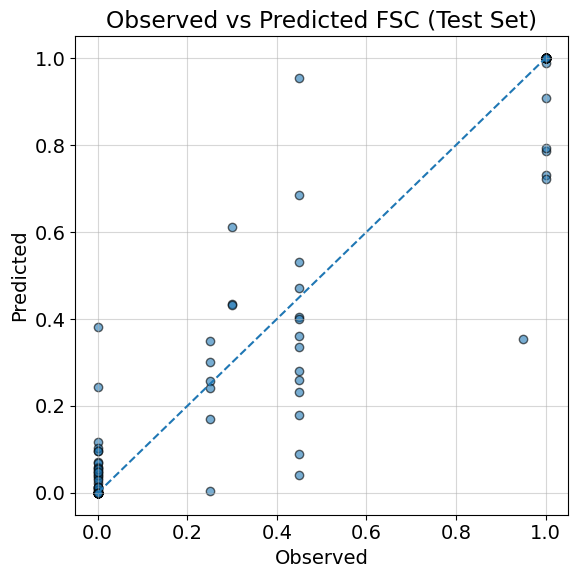

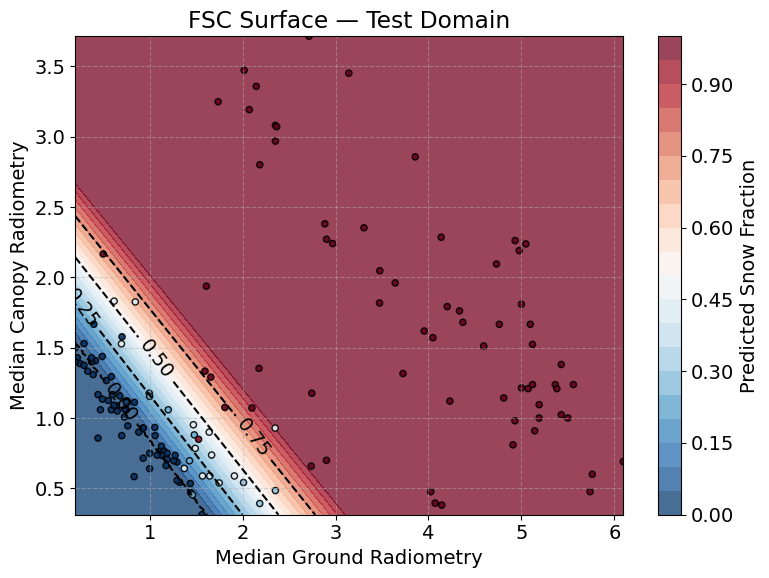

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

# ------------------------------ config ------------------------------
EG_COL = "Eg_strong"
EV_COL = "Ev_strong"
Y_COL  = "JointSnowBinary"  # observed FSC (0..1)
FRAC_W = 1.0
BIN_W  = 0.15        # relative weight for binary points in the objective
GRID_N = 300        # resolution for the contour grid

# ------------------------------ helpers ------------------------------
def mod2pi(x):
    return np.mod(x, 2*np.pi)

def dccw(a, b):
    """Counter-clockwise angular distance from a to b, both in [0, 2π)."""
    return mod2pi(b - a)

def weighted_rmse(y_true, y_pred, frac_weight=1.0, bin_weight=0.25):
    """Heavily weight fractional points (0<y<1), lightly weight binary (0/1)."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    w = np.where((y_true > 0) & (y_true < 1), frac_weight, bin_weight)
    return np.sqrt(np.sum(w * (y_true - y_pred) ** 2) / np.sum(w))

def angular_sector_map(eg, ev, cx, cy, theta1, theta2, eps=1e-9):
    """
    Sector model:
      - value=0 at theta1, value=1 at theta2 along CCW arc (linear ramp)
      - clockwise of theta1 -> 0; counterclockwise of theta2 (up to pi) -> 1
      - at theta0 = pi -> 0 (jump)
      - center point -> 0
    """
    eg = np.asarray(eg); ev = np.asarray(ev)
    theta = mod2pi(np.arctan2(ev - cy, eg - cx))
    t1 = mod2pi(theta1)
    t2 = mod2pi(theta2)
    pi_m = mod2pi(np.pi)

    arc = dccw(t1, t2)
    arc = np.maximum(arc, eps)

    d1 = dccw(t1, theta)

    in_grad = d1 <= arc + eps
    vals = np.empty_like(theta, dtype=float)
    vals[in_grad] = np.clip(d1[in_grad] / arc, 0.0, 1.0)

    d_from_t2 = dccw(t2, theta)
    d_t2_to_pi = dccw(t2, pi_m)

    in_high = (~in_grad) & (d_from_t2 < d_t2_to_pi - eps)
    vals[in_high] = 1.0
    vals[~(in_grad | in_high)] = 0.0

    at_pi = np.isclose(mod2pi(theta), pi_m, atol=1e-12)
    vals[at_pi] = 0.0

    at_center = np.isclose(eg, cx, atol=1e-12) & np.isclose(ev, cy, atol=1e-12)
    vals[at_center] = 0.0
    return vals

def tiny_arc_penalty(theta1, theta2, thresh=1e-3):
    arc = dccw(mod2pi(theta1), mod2pi(theta2))
    if arc < thresh:
        return 1e6 * (thresh - arc + 1e-9)
    return 0.0

# ------------------------------ fit & predict ------------------------------
def fit_sector_model(train_df):
    data = train_df.dropna(subset=[EG_COL, EV_COL, Y_COL]).copy()
    eg = data[EG_COL].values
    ev = data[EV_COL].values
    y  = data[Y_COL].astype(float).values

    eg_min, eg_max = float(np.min(eg)), float(np.max(eg))
    ev_min, ev_max = float(np.min(ev)), float(np.max(ev))
    margin_eg = max(0.5, 0.05*(eg_max-eg_min))
    margin_ev = max(0.5, 0.05*(ev_max-ev_min))

    def init_params():
        # a decent generic starting point
        return np.array([0.0, 1.8, -np.pi/4, -np.pi/8], dtype=float)

    bounds = [
        (-np.inf, 0.0),              # cx <= 0
        (max(1e-6, 0.0), np.inf),   # cy > 0 (approx)
        (-np.pi/2, np.pi),                      # theta1 >= -pi/2
        (-np.pi, 0.0),                          # theta2 <= 0
    ]

    def objective(p):
        cx, cy, t1, t2 = p
        y_hat = angular_sector_map(eg, ev, cx, cy, t1, t2)
        return weighted_rmse(y, y_hat, frac_weight=FRAC_W, bin_weight=BIN_W) + tiny_arc_penalty(t1, t2)

    res = minimize(objective, init_params(), method="L-BFGS-B", bounds=bounds)
    cx, cy, t1, t2 = res.x
    params = {"cx": cx, "cy": cy, "theta1": t1, "theta2": t2,
              "eg_min": eg_min, "eg_max": eg_max, "ev_min": ev_min, "ev_max": ev_max}
    return params

def predict_sector(df, params):
    eg = df[EG_COL].values
    ev = df[EV_COL].values
    p  = angular_sector_map(eg, ev, params["cx"], params["cy"], params["theta1"], params["theta2"])
    return np.clip(p, 0.0, 1.0)

# ------------------------------ metrics ------------------------------
def compute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    overall_rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    overall_bias = float(np.mean(y_pred - y_true))

    frac_mask = (y_true > 0) & (y_true < 1)
    if np.any(frac_mask):
        frac_rmse = float(np.sqrt(mean_squared_error(y_true[frac_mask], y_pred[frac_mask])))
        frac_bias = float(np.mean(y_pred[frac_mask] - y_true[frac_mask]))
    else:
        frac_rmse = np.nan
        frac_bias = np.nan

    return dict(
        overall_rmse=overall_rmse,
        overall_bias=overall_bias,
        overall_frac_rmse=frac_rmse,
        overall_frac_bias=frac_bias
    )

def print_metrics(m):
    print("\n=== Test Metrics ===")
    print(f"Overall RMSE:           {m['overall_rmse']:.4f}")
    print(f"Overall Bias:           {m['overall_bias']:.4f}")
    print(f"Fractional RMSE:        {m['overall_frac_rmse']:.4f}" if np.isfinite(m['overall_frac_rmse']) else "Fractional RMSE:        n/a")
    print(f"Fractional Bias:        {m['overall_frac_bias']:.4f}" if np.isfinite(m['overall_frac_bias']) else "Fractional Bias:        n/a")

# ------------------------------ plotting ------------------------------
def plot_binary_prediction_distribution(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask0 = y_true == 0
    mask1 = y_true == 1

    bins = np.arange(0.0, 1.05, 0.05)
    c0, _ = np.histogram(y_pred[mask0], bins=bins)
    c1, _ = np.histogram(y_pred[mask1], bins=bins)
    centers = 0.5 * (bins[:-1] + bins[1:])

    plt.figure(figsize=(7,5))
    plt.plot(centers, c0, label="Observed y=0")
    plt.fill_between(centers, 0, c0, alpha=0.3)
    plt.plot(centers, c1, label="Observed y=1")
    plt.fill_between(centers, 0, c1, alpha=0.3)
    plt.xlabel("Predicted FSC")
    plt.ylabel("Count")
    plt.title("Distribution of Predictions for Observed y=0 vs y=1 (Test Set)")
    plt.legend()
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()

def plot_obs_vs_pred(y_true, y_pred, title="Observed vs Predicted FSC (Test Set)"):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolor='k')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("Observed")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_test_contour(test_df, params, title="FSC Surface — Test Domain"):
    eg = test_df[EG_COL].values
    ev = test_df[EV_COL].values
    y  = test_df[Y_COL].astype(float).values

    eg_min, eg_max = float(np.min(eg)), float(np.max(eg))
    ev_min, ev_max = float(np.min(ev)), float(np.max(ev))

    eg_vals = np.linspace(eg_min, eg_max, GRID_N)
    ev_vals = np.linspace(ev_min, ev_max, GRID_N)
    EG, EV = np.meshgrid(eg_vals, ev_vals)

    Z = angular_sector_map(EG, EV, params["cx"], params["cy"], params["theta1"], params["theta2"])

    fig, ax = plt.subplots(figsize=(8,6))
    cs = ax.contourf(EG, EV, Z, levels=np.linspace(0,1,21), cmap='RdBu_r', alpha=0.75)
    cbar = fig.colorbar(cs, ax=ax); cbar.set_label("Predicted Snow Fraction")
    lines = ax.contour(EG, EV, Z, levels=[0,0.25,0.5,0.75,1], colors='k', linestyles='--')
    ax.clabel(lines, fmt='%1.2f')

    sc = ax.scatter(eg, ev, c=y, cmap='RdBu_r', edgecolor='k', s=20, vmin=0, vmax=1, alpha=0.9)
    ax.set_xlabel("Median Ground Radiometry")
    ax.set_ylabel("Median Canopy Radiometry")
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# ------------------------------ usage ------------------------------
from scripts.imports import *
df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_70m_1kmsmallbox_noprior_ta_v7.pkl')
df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Ev'], np.nan)
df['Eg_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_weak'] = np.where((df['beam_str'] == 'weak')&(df['outlier'] == 1), df['Ev'], np.nan)
df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'Eg_weak': 'median',
    'Ev_weak': 'median',
    'data_quantity': 'max',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
frac_data = df_grouped[((df_grouped['FSC'] >= 0.00)&(df_grouped['FSC'] <= 1.00))
    &(df_grouped['Eg_strong'] <= 16)&(df_grouped['Ev_strong'] <= 16)
    &(df_grouped['Eg_strong']/df_grouped['Eg_weak'] >= 1.15)
    # &((df_grouped['layer_flag'] <= 0.6)&(df_grouped['msw_flag'] <= 3.0))
    &(df_grouped['data_quantity'] >= 26)].copy()
frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)
# frac_data = frac_data[~frac_data['camera'].isin(['delta_junction', 'marcell_MN', 'glees'])]

# Provide your dataframes:
train_df = frac_data[~frac_data['camera'].isin(['delta_junction', 'marcell_MN', 'glees'])].copy()
test_df  = frac_data[frac_data['camera'].isin(['delta_junction', 'marcell_MN', 'glees'])].copy()

# 1) Fit on ALL training data
params = fit_sector_model(train_df)
print("Fitted parameters:", params)

# 2) Apply to test dataframe
y_pred_test = predict_sector(test_df, params)
y_true_test = test_df[Y_COL].astype(float).values

# 3) Metrics
m = compute_metrics(y_true_test, y_pred_test)
print_metrics(m)
overall_rmse, overall_bias, overall_frac_rmse, overall_frac_bias = m['overall_rmse'], m['overall_bias'],\
                                                                    m['overall_frac_rmse'], m['overall_frac_bias']

# 4) Plots
plot_binary_prediction_distribution(y_true_test, y_pred_test)
plot_obs_vs_pred(y_true_test, y_pred_test)
plot_test_contour(test_df, params)


# combining plots from landsat and icesat-2

In [14]:
from scripts.imports import *
from rasterio.enums import Resampling
from shapely.geometry import Polygon, Point

def find_masks(folder, cam):
    for filename in os.listdir(folder):
        if cam in filename and 'LandCover' in filename:
            corine_filepath = os.path.join(folder, filename)
        elif cam in filename and 'ALOS' in filename:
            elevation_filepath = os.path.join(folder, filename)
    return corine_filepath, elevation_filepath

def load_and_reproject_to_landsat(source_path, match_array, band_name, method=Resampling.nearest):
    src = rioxarray.open_rasterio(source_path, masked=True).squeeze()
    src.name = band_name
    return src.rio.reproject_match(match_array, resampling=method)

def combine_tifs(landsat_filepath, corine_filepath, elevation_filepath):
    landsat = rioxarray.open_rasterio(landsat_filepath, masked=True).squeeze()
    landsat.name = "landsat"
    corine = load_and_reproject_to_landsat(corine_filepath, landsat, "corine_landcover")
    elevation = load_and_reproject_to_landsat(elevation_filepath, landsat, "elevation")
    return xr.merge([landsat, corine, elevation])

def apply_valid_mask(ds, e=80):
    elevation = ds['elevation']
    corine = ds['corine_landcover']
    yc, xc = elevation.sizes['y'] // 2, elevation.sizes['x'] // 2
    centre_elev = elevation.isel(y=yc, x=xc).item()
    elev_mask = np.abs(elevation - centre_elev) <= e
    corine_mask = (corine >= 111) & (corine <= 126)
    valid_mask = elev_mask & corine_mask
    ds['valid_mask'] = valid_mask
    return ds

def compute_ndvi(red, nir):
    return (nir - red) / (nir + red)

def compute_ndsi(green, swir):
    return (green - swir) / (green + swir)

def compute_dozier(ds, ndsi, nir):
    corine = ds['corine_landcover']
    condition1 = (ndsi > 0.1) & (ndsi < 0.4) # & (corine >= 111) & (corine <= 126)
    condition2 = (ndsi >= 0.4) & (nir > 0.11) # ~((corine >= 111) & (corine <= 126))
    dozier = xr.where(condition1 | condition2, 1, 0)
    return dozier.where(~np.isnan(ndsi))

def compute_klein(ndsi, ndvi, green, nir):
    region_coords = [
        (0.4, 1), (0.33, 0.91), (0.26, 0.75),
        (0.2, 0.6), (0.1, 0.25), (0.4, 0.1),
    ]
    polygon = Polygon(region_coords)
    klein = xr.zeros_like(ndsi)
    klein = xr.where(ndsi >= 0.4, 1, klein)
    ndsi_vals, ndvi_vals = ndsi.values, ndvi.values
    mask = np.zeros(ndsi.shape, dtype=bool)
    for i in range(ndsi.shape[0]):
        for j in range(ndsi.shape[1]):
            if not np.isnan(ndsi_vals[i, j]) and not np.isnan(ndvi_vals[i, j]):
                if polygon.contains(Point(ndsi_vals[i, j], ndvi_vals[i, j])):
                    mask[i, j] = True
    klein = xr.where(xr.DataArray(mask, dims=ndsi.dims, coords=ndsi.coords), 1, klein)
    klein = xr.where((green <= 0.1) | (nir <= 0.11), 0, klein)
    return klein.where(~np.isnan(ndsi) & ~np.isnan(ndvi))

def compute_salomonson(ndsi):
    fsc = 0.06 + 1.21 * ndsi
    return fsc.clip(0, 1).where(~np.isnan(ndsi))

def normalize(img):
    img = img.transpose("y", "x", "band")
    p2 = img.quantile(0.02, dim=("x", "y"))
    p98 = img.quantile(0.98, dim=("x", "y"))
    return ((img - p2) / (p98 - p2)).clip(0, 1)

def plot_rgb(ds, landsat, cam, filtered=True):
    rgb_bands = [2, 1, 0] if landsat == 'Landsat7' else [3, 2, 1]
    rgb = ds['landsat'].isel(band=rgb_bands)

    if filtered and 'valid_mask' in ds:
        # Apply valid mask across all bands
        mask = ds['valid_mask']
        rgb = rgb.where(mask)

    rgb = normalize(rgb)

    plt.figure(figsize=(8, 8))
    title = f"RGB Composite for {cam}" + (" (Filtered)" if filtered else " (Raw)")
    plt.imshow(rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

import os
import re

def process_scene(i, apply_filter=True, plot_rgb_image=True, e=80):
    cams = ['bartlett', 'delta_junction', 'glees', 'hyytiala', 'kenttarova', 'lacclair', 'marcell', 'old_jack_pine',
            'oregon', 'queens', 'sodankyla', 'torgnon', 'underc', 'underhill', 'varrio', 'willowcreek', 'wslcreek']

    landsat_folder = '../scratch/data/landsat/'
    landsat_filepaths = sorted([
        os.path.join(landsat_folder, f) for f in os.listdir(landsat_folder)
        if os.path.isfile(os.path.join(landsat_folder, f))
    ])

    filepath = landsat_filepaths[i]
    cam = [c for c in cams if c in filepath][0]
    landsat = [l for l in ['Landsat7', 'Landsat8'] if l in filepath][0]

    # Extract FSC number from filename (e.g. 'bartlett80_')
    match = re.search(rf"{cam}(\d+)_", os.path.basename(filepath))
    fsc_value = int(match.group(1)) if match else None

    landsat_masking_folder = '../scratch/data/landsat_masking/'
    corine_fp, elev_fp = find_masks(landsat_masking_folder, cam)
    print(f"Processing i={i}: {filepath}")
    
    ds = combine_tifs(filepath, corine_fp, elev_fp)
    ds = apply_valid_mask(ds, e)

    bgrns = [1, 2, 3, 4, 5] if landsat == 'Landsat7' else [2, 3, 4, 5, 6]
    red, green, blue, nir, swir = [ds['landsat'].isel(band=b - 1) for b in bgrns]

    ndsi = compute_ndsi(green, swir)
    ndvi = compute_ndvi(red, nir)

    dozier = compute_dozier(ds, ndsi, nir)
    klein = compute_klein(ndsi, ndvi, green, nir)
    fsc = compute_salomonson(ndsi)
    if apply_filter:
        dozier = dozier.where(ds['valid_mask'])
        klein = klein.where(ds['valid_mask'])
        fsc = fsc.where(ds['valid_mask'])
    
    ds['Dozier'] = dozier.assign_attrs(name="Dozier")
    ds['Klein'] = klein.assign_attrs(name="Klein")
    ds['Salomonson'] = fsc.assign_attrs(name="Salomonson")

    if plot_rgb_image:
        plot_rgb(ds, landsat, cam, filtered=False)

    return ds, fsc_value, cam

def subcell_stats(ds, var='Salomonson', apply_filter=True, extent=4):
    """
    Compute mean value and valid_mask fraction in fixed 8x8 grid over dataset in meters.

    Args:
        ds (xr.Dataset): Dataset with 2D variable `var` and 'valid_mask'
        var (str): Variable to average (default: 'Salomonson')
        apply_filter (bool): If True, use 'valid_mask' to filter pixels before averaging

    Returns:
        pd.DataFrame with columns: ['cell_y', 'cell_x', 'mean', 'filtered_fraction']
    """
    data = ds[var]
    mask = ds['valid_mask']

    # Get coordinates
    y_vals = data['y'].values
    x_vals = data['x'].values
    yy, xx = np.meshgrid(y_vals, x_vals, indexing="ij")

    flat_y = yy.ravel()
    flat_x = xx.ravel()
    flat_data = data.values.ravel()
    flat_mask = mask.values.ravel()

    # Get bounding box and define 8 even bins in each direction
    y_min, y_max = y_vals.min(), y_vals.max()
    x_min, x_max = x_vals.min(), x_vals.max()

    y_edges = np.linspace(y_min, y_max, 9)  # 8 bins = 9 edges
    x_edges = np.linspace(x_min, x_max, 9)

    # Digitize assigns bin 1–8; subtract 1 → 0–7 for indexing
    cell_y = np.digitize(flat_y, y_edges) - 1
    cell_x = np.digitize(flat_x, x_edges) - 1

    # Keep only points within bin ranges
    valid = (cell_y >= 4 - extent) & (cell_y < 4 + extent) & (cell_x >= 4 - extent) & (cell_x < 4 + extent)

    df = pd.DataFrame({
        'cell_y': cell_y[valid],
        'cell_x': cell_x[valid],
        'data': flat_data[valid],
        'mask': flat_mask[valid]
    })

    # if apply_filter:
    #     df = df[df['mask'] == True]

    grouped = df.groupby(['cell_y', 'cell_x'], as_index=False).agg(
        mean=('data', 'mean'),
        filtered_fraction=('mask', lambda v: np.count_nonzero(v == True) / np.count_nonzero(~np.isnan(v)))
        if apply_filter else
        ('mask', lambda v: 1.0)  # If not filtering, assume full coverage
    )

    return grouped

N = len([f for f in os.listdir('../scratch/data/landsat/') if os.path.isfile(os.path.join('../scratch/data/landsat/', f))])
print(N)

merged_results = []

for i in range(N):  # or range(1) for testing
    ds, fsc, cam = process_scene(i=i, apply_filter=True, plot_rgb_image=False, e=70)
    
    print(fsc)
    fsc_norm = fsc / 100

    # fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
    
    # ds.Dozier.plot(ax=axes[0])
    # axes[0].set_title("Dozier")
    
    # ds.Klein.plot(ax=axes[1])
    # axes[1].set_title("Klein")
    
    # ds.Salomonson.plot(ax=axes[2])
    # axes[2].set_title("Salomonson")
    
    # plt.tight_layout()
    # plt.show()

    # Get results for all three metrics
    dozier = subcell_stats(ds, var='Dozier', apply_filter=True, extent=4)
    klein = subcell_stats(ds, var='Klein', apply_filter=True, extent=4)
    # salo  = subcell_stats(ds, var='Salomonson', apply_filter=True, extent=4)

    # Filter by valid fraction
    dozier = dozier.where(dozier['filtered_fraction'] >= 0.2).dropna()
    klein  = klein.where(klein['filtered_fraction'] >= 0.2).dropna()
    # salo   = salo.where(salo['filtered_fraction'] >= 0.2).dropna()

    # Merge on cell_x and cell_y
    merged = dozier[['cell_y', 'cell_x', 'filtered_fraction', 'mean']].rename(columns={'mean': 'Dozier'}) \
        .merge(klein[['cell_y', 'cell_x', 'mean']].rename(columns={'mean': 'Klein'}), on=['cell_y', 'cell_x']) \
        # .merge(salo[['cell_y', 'cell_x', 'mean']].rename(columns={'mean': 'Salomonson'}), on=['cell_y', 'cell_x'])

    # Add fsc column
    merged['fsc'] = fsc_norm
    merged['cam'] = cam
    merged_results.append(merged)

# Final DataFrame
final_df = pd.concat(merged_results, ignore_index=True)

print(final_df)

58
Processing i=0: ../scratch/data/landsat/Landsat7_bartlett80_clouds4_LE07_L2SP_013029_20220323_20220419_02_T1.tif
80
Processing i=1: ../scratch/data/landsat/Landsat7_hyytiala95_clouds6_LE07_L2SP_189017_20190417_20200827_02_T1.tif
95
Processing i=2: ../scratch/data/landsat/Landsat7_kenttarova98_clouds0_LE07_L2SP_192012_20200526_20200820_02_T1.tif
98
Processing i=3: ../scratch/data/landsat/Landsat7_lacclair90_clouds0_LE07_L2SP_013027_20190502_20200825_02_T1.tif
90
Processing i=4: ../scratch/data/landsat/Landsat7_marcell100_clouds12_LE07_L2SP_028027_20200326_20200822_02_T1.tif
100
Processing i=5: ../scratch/data/landsat/Landsat7_marcell60_clouds0_LE07_L2SP_027027_20210306_20210401_02_T1.tif
60
Processing i=6: ../scratch/data/landsat/Landsat7_marcell70_clouds0_LE07_L2SP_027027_20200404_20200822_02_T1.tif
70
Processing i=7: ../scratch/data/landsat/Landsat7_marcell80_clouds0_LE07_L2SP_028027_20210313_20210410_02_T1.tif
80
Processing i=8: ../scratch/data/landsat/Landsat7_old_jack_pine44_clo

/tmp/ipykernel_2909147/3051639847.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df = melted.groupby("method", as_index=False).apply(compute_rmse_bias).reset_index(drop=True)


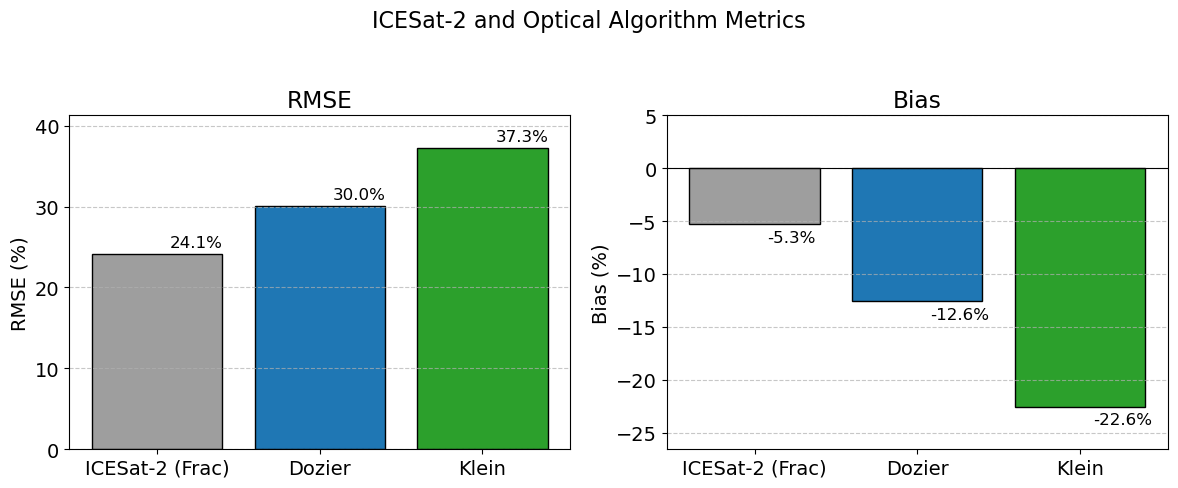

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Expects these to already exist:
# - final_df with columns ['fsc','filtered_fraction','cam','Dozier','Klein','Salomonson']
# - overall_rmse, overall_bias, overall_frac_rmse, overall_frac_bias (from your OOF script)
# -------------------------------------------------------------------

# Compute per-method RMSE/Bias from final_df
melted = final_df.melt(
    id_vars=["fsc", "filtered_fraction", "cam"],
    value_vars=["Dozier", "Klein"],#, "Salomonson"],
    var_name="method",
    value_name="predicted"
)

def compute_rmse_bias(g):
    rmse = np.sqrt(np.mean((g["predicted"] - g["fsc"])**2)) * 100
    bias = np.mean(g["predicted"] - g["fsc"]) * 100
    return pd.Series({"RMSE": rmse, "Bias": bias})

metrics_df = melted.groupby("method", as_index=False).apply(compute_rmse_bias).reset_index(drop=True)

methods = ["Dozier", "Klein"]#, "Salomonson"]
rmse_vals = [metrics_df.loc[metrics_df["method"] == m, "RMSE"].values[0] for m in methods]
bias_vals = [metrics_df.loc[metrics_df["method"] == m, "Bias"].values[0] for m in methods]

# Add overall metrics (from OOF predictions, scaled to %)
labels = ['ICESat-2 (Frac)'] + methods
rmse_all = [overall_frac_rmse * 100] + rmse_vals
bias_all = [overall_frac_bias * 100] + bias_vals

# Colors
colors = {
    "ICESat-2 (Frac)": "#9e9e9e",
    "Dozier": "#1f77b4",
    "Klein": "#2ca02c",
    # "Salomonson": "#d62728",
}

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax_rmse, ax_bias = axes

# RMSE panel
x_rmse = np.arange(len(labels))
bars_rmse = ax_rmse.bar(x_rmse, rmse_all,
                        color=[colors[l] for l in labels], edgecolor='black')
ax_rmse.set_xticks(x_rmse)
ax_rmse.set_xticklabels(labels, rotation=0)
ax_rmse.set_ylabel("RMSE (%)")
ax_rmse.set_title("RMSE")
ax_rmse.grid(axis='y', linestyle='--', alpha=0.7)

# Labels on bars
for bar, val in zip(bars_rmse, rmse_all):
    x_offset = bar.get_x() + bar.get_width() * 0.6
    y_offset = 0.5 * np.sign(val)  # adjust offset for %
    ax_rmse.text(x_offset, val + y_offset, f"{val:.1f}%",
                 ha='left', va='bottom' if val >= 0 else 'top', fontsize=12)

# y-limits with padding
ymin_r = min(0, min(rmse_all) - 4)
ymax_r = (max(rmse_all) + 4) if max(rmse_all) > 0 else 5
ax_rmse.set_ylim(ymin_r, ymax_r)

# Bias panel
x_bias = np.arange(len(labels))
bars_bias = ax_bias.bar(x_bias, bias_all,
                        color=[colors[l] for l in labels], edgecolor='black')
ax_bias.set_xticks(x_bias)
ax_bias.set_xticklabels(labels, rotation=0)
ax_bias.set_ylabel("Bias (%)")
ax_bias.set_title("Bias")
ax_bias.axhline(0, color='black', lw=0.8)
ax_bias.grid(axis='y', linestyle='--', alpha=0.7)

for bar, val in zip(bars_bias, bias_all):
    x_offset = bar.get_x() + bar.get_width() * 0.6
    y_offset = 0.5 * np.sign(val)
    ax_bias.text(x_offset, val + y_offset, f"{val:.1f}%",
                 ha='left', va='bottom' if val >= 0 else 'top', fontsize=12)

ymin_b = min(0, min(bias_all) - 4)
ymax_b = max(0, max(bias_all) + 4) if max(bias_all) > 0 else 5
ax_bias.set_ylim(ymin_b, ymax_b)

plt.suptitle("ICESat-2 and Optical Algorithm Metrics", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
